![](https://storage.googleapis.com/kaggle-media/competitions/House%20Prices/kaggle_5407_media_housesbanner.png)

# House Prices Prediction

In [118]:
import numpy as np

import matplotlib.pyplot as plt

import pandas as pd

import seaborn as sns

import tensorflow as tf
from keras.utils.vis_utils import plot_model
from keras.utils.vis_utils import plot_model


from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import r2_score
from sklearn.metrics import mean_absolute_percentage_error
from sklearn.metrics import mean_squared_log_error
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import train_test_split
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.model_selection import KFold
from sklearn.metrics import accuracy_score
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import GridSearchCV

import xgboost as xgb
from xgboost import XGBRegressor
from xgboost import plot_tree

from lightgbm import LGBMRegressor

from catboost import CatBoostRegressor

from scipy. stats import boxcox 


import collections

# Ignore useless warnings
import warnings
warnings.filterwarnings(action="ignore")
pd.options.display.max_seq_items = 8000
pd.options.display.max_rows = 8000

# from tensorflow.keras.layers.Layer import Sequential, Dense, ReLU
# Попросите покупателя дома описать дом своей мечты, 
# и он, вероятно, не начнет с высоты потолка подвала 
# или близости к железной дороге с востока на запад. 
# Но набор данных этого конкурса игровых площадок доказывает, 
# что гораздо больше влияет на ценовые переговоры, 
# чем количество спален или забор из белого штакетника.

# С 79 независимыми переменными, описывающими (почти) каждый аспект жилых домов в Эймсе, 
# штат Айова, этот конкурс ставит перед вами задачу предсказать окончательную цену каждого дома.

# Читаем и изучаем полученные данные

**Читаем данные и обрезаем Id столбец, он не нужен для обучения** 

In [119]:
data_train = pd.read_csv(r'train.csv')
data_train = data_train.drop('Id', axis=1)

data_test = pd.read_csv(r'test.csv')
data_test = data_test.drop('Id',axis=1)

data_test['SalePrice'] = np.zeros(len(data_test))
length_test = len(data_test)
length_train = len(data_train)
print(length_test)
print(length_train)
print(length_test + length_train)

1459
1460
2919


In [120]:
data_train = pd.concat([data_train, data_test], ignore_index=True)
# data_train

После конкатинации количество строк совпадает 

**Выводим первые пять строк**

In [121]:
data_train.head(5)

MSSubClass MSZoning  LotFrontage  LotArea Street Alley LotShape  \
0          60       RL         65.0     8450   Pave   NaN      Reg   
1          20       RL         80.0     9600   Pave   NaN      Reg   
2          60       RL         68.0    11250   Pave   NaN      IR1   
3          70       RL         60.0     9550   Pave   NaN      IR1   
4          60       RL         84.0    14260   Pave   NaN      IR1   

  LandContour Utilities LotConfig  ... PoolArea PoolQC Fence MiscFeature  \
0         Lvl    AllPub    Inside  ...        0    NaN   NaN         NaN   
1         Lvl    AllPub       FR2  ...        0    NaN   NaN         NaN   
2         Lvl    AllPub    Inside  ...        0    NaN   NaN         NaN   
3         Lvl    AllPub    Corner  ...        0    NaN   NaN         NaN   
4         Lvl    AllPub       FR2  ...        0    NaN   NaN         NaN   

  MiscVal MoSold  YrSold  SaleType  SaleCondition  SalePrice  
0       0      2    2008        WD         Normal   208500.0  
1       0      5    2007        WD         Normal   181500.0  
2       0      9    2008        WD         Normal   223500.0  
3       0      2    2006        WD        Abnorml   140000.0  
4       0     12    2008        WD         Normal   250000.0  

[5 rows x 80 columns]

**Необходимо произвести поиск и заполнение отсутствующих значений**

Я использовал функцию участника соревнования Kaggle https://www.kaggle.com/code/lavanyashukla01/how-i-made-top-0-3-on-a-kaggle-competition

In [122]:
def ProcentOfMissingValue(data_train):
    missing = (round(data_train.isnull().mean()*100,10)) 
    missing = missing[missing>0].sort_values(ascending=False)
    plt.figure(figsize=(15,5))
    missing.plot.bar()
    # plt.axis("Percent of missing values")
    plt.ylabel("Percent of missing values")
    plt.xlabel("Features")
    plt.show()
    print('Процент пропущенных значений в столбцах')
    print(missing)
    print('------------------------------------------------')
    for i in missing.index:
        print(i, data_train[i].dtype)
    
# ProcentOfMissingValue(data_train)

**Проверяем типы данных в которых отсутствую значения**

In [123]:
# for i in missing.index:
#     print(i, data_train[i].dtype)

Теоретически, можно вычислить значения которые пропущены и восстановить их. Изучим на основе цены и значений какими могут быть пропущенные значения.

1.PoolQC - качество бассейна

In [124]:
data_train['PoolQC'].value_counts()

Ex    4
Gd    4
Fa    2
Name: PoolQC, dtype: int64

Мы видим, что имеется 3 класса Хорошо, прекрасно и средне. Но также имеется еще одна графа PoolArea, отображающая площадь бассейна, соответственно если данное значение равно нулю, то можно вместо значения в графе PollQC NaN заменить на None.

In [125]:
data_train['PoolArea'].value_counts()

0      2906
512       1
648       1
576       1
555       1
480       1
519       1
738       1
144       1
368       1
444       1
228       1
561       1
800       1
Name: PoolArea, dtype: int64

In [126]:
data_train['PoolQC'] = data_train['PoolQC'].fillna(value = 'None')

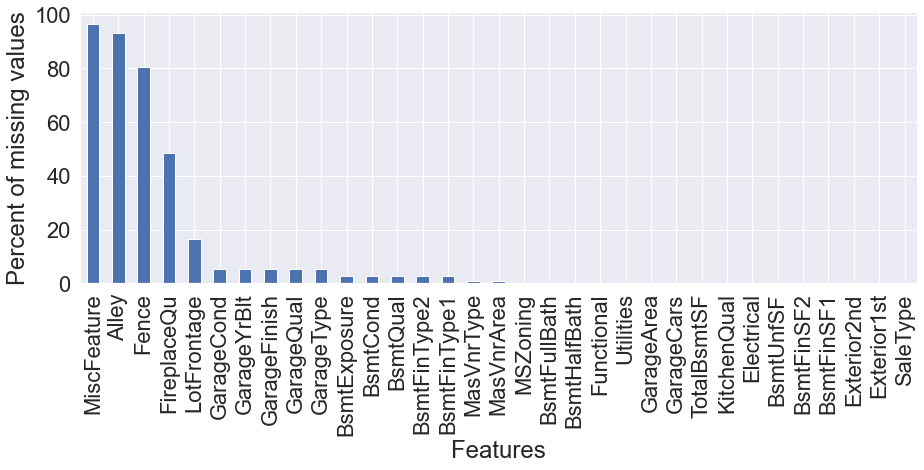

Процент пропущенных значений в столбцах
MiscFeature     96.402878
Alley           93.216855
Fence           80.438506
FireplaceQu     48.646797
LotFrontage     16.649538
GarageCond       5.447071
GarageYrBlt      5.447071
GarageFinish     5.447071
GarageQual       5.447071
GarageType       5.378554
BsmtExposure     2.809181
BsmtCond         2.809181
BsmtQual         2.774923
BsmtFinType2     2.740665
BsmtFinType1     2.706406
MasVnrType       0.822199
MasVnrArea       0.787941
MSZoning         0.137033
BsmtFullBath     0.068517
BsmtHalfBath     0.068517
Functional       0.068517
Utilities        0.068517
GarageArea       0.034258
GarageCars       0.034258
TotalBsmtSF      0.034258
KitchenQual      0.034258
Electrical       0.034258
BsmtUnfSF        0.034258
BsmtFinSF2       0.034258
BsmtFinSF1       0.034258
Exterior2nd      0.034258
Exterior1st      0.034258
SaleType         0.034258
dtype: float64
------------------------------------------------
MiscFeature object
Alley object
Fence 

In [127]:
ProcentOfMissingValue(data_train)

Как видно, одно значение было заменено

2. MiscFeature

In [128]:
data_train['MiscFeature'].value_counts()

Shed    95
Gar2     5
Othr     4
TenC     1
Name: MiscFeature, dtype: int64

Shed - сарай

Gar2 - Второй гараж


Построим диаграмму рассеивания класса и цены.

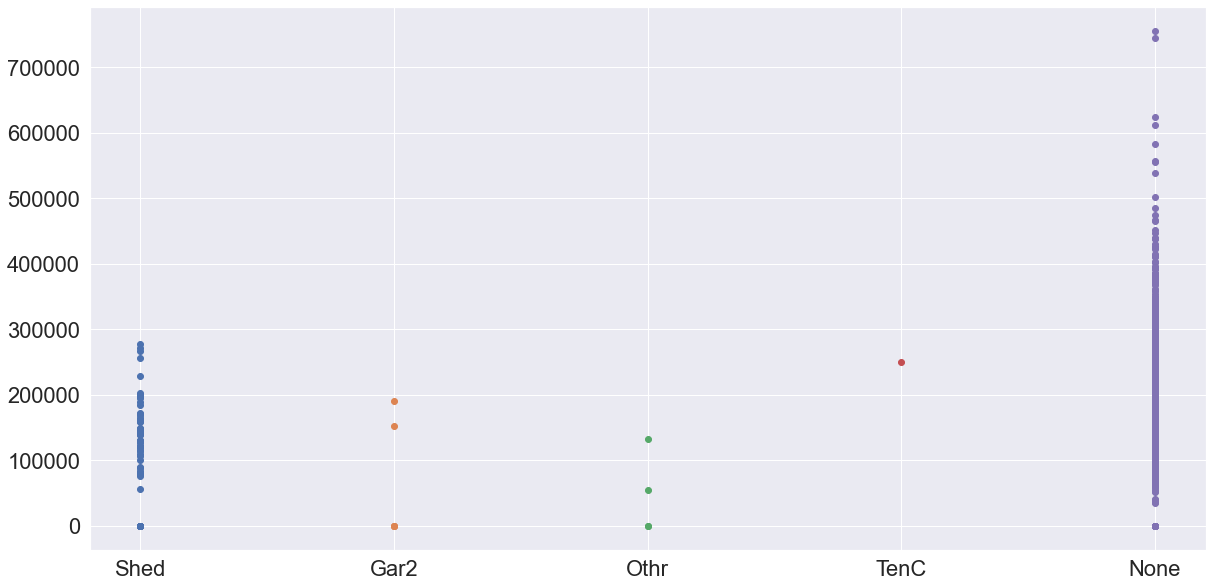

In [129]:
plt.figure(figsize=(20,10))
plt.scatter(data_train[data_train['MiscFeature'] == 'Shed']['MiscFeature'],data_train[data_train['MiscFeature'] == 'Shed']['SalePrice'])
plt.scatter(data_train[data_train['MiscFeature'] == 'Gar2']['MiscFeature'],data_train[data_train['MiscFeature'] == 'Gar2']['SalePrice'])
plt.scatter(data_train[data_train['MiscFeature'] == 'Othr']['MiscFeature'],data_train[data_train['MiscFeature'] == 'Othr']['SalePrice'])
plt.scatter(data_train[data_train['MiscFeature'] == 'TenC']['MiscFeature'],data_train[data_train['MiscFeature'] == 'TenC']['SalePrice'])
plt.scatter(data_train[data_train['MiscFeature'].isna() == True]['MiscFeature'].fillna(value = 'None'), data_train[data_train['MiscFeature'].isna() == True]['SalePrice'])
plt.show()

Мы можем предположить, что у других домов отсутствуют дополнительные значения.

In [130]:
data_train['MiscFeature'] = data_train['MiscFeature'].fillna(value = 'None')

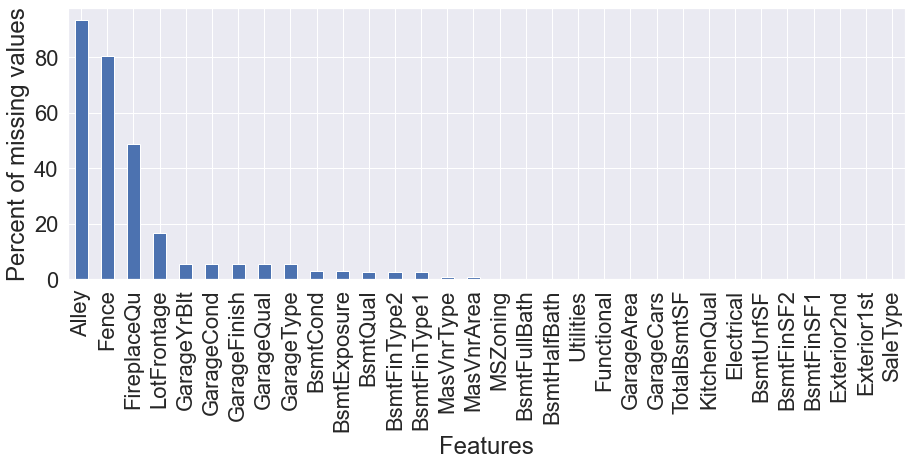

Процент пропущенных значений в столбцах
Alley           93.216855
Fence           80.438506
FireplaceQu     48.646797
LotFrontage     16.649538
GarageYrBlt      5.447071
GarageCond       5.447071
GarageFinish     5.447071
GarageQual       5.447071
GarageType       5.378554
BsmtCond         2.809181
BsmtExposure     2.809181
BsmtQual         2.774923
BsmtFinType2     2.740665
BsmtFinType1     2.706406
MasVnrType       0.822199
MasVnrArea       0.787941
MSZoning         0.137033
BsmtFullBath     0.068517
BsmtHalfBath     0.068517
Utilities        0.068517
Functional       0.068517
GarageArea       0.034258
GarageCars       0.034258
TotalBsmtSF      0.034258
KitchenQual      0.034258
Electrical       0.034258
BsmtUnfSF        0.034258
BsmtFinSF2       0.034258
BsmtFinSF1       0.034258
Exterior2nd      0.034258
Exterior1st      0.034258
SaleType         0.034258
dtype: float64
------------------------------------------------
Alley object
Fence object
FireplaceQu object
LotFrontage float64

In [131]:
ProcentOfMissingValue(data_train)

3. Alley Тип доступа к аллее

In [132]:
data_train['Alley'].value_counts()

Grvl    120
Pave     78
Name: Alley, dtype: int64

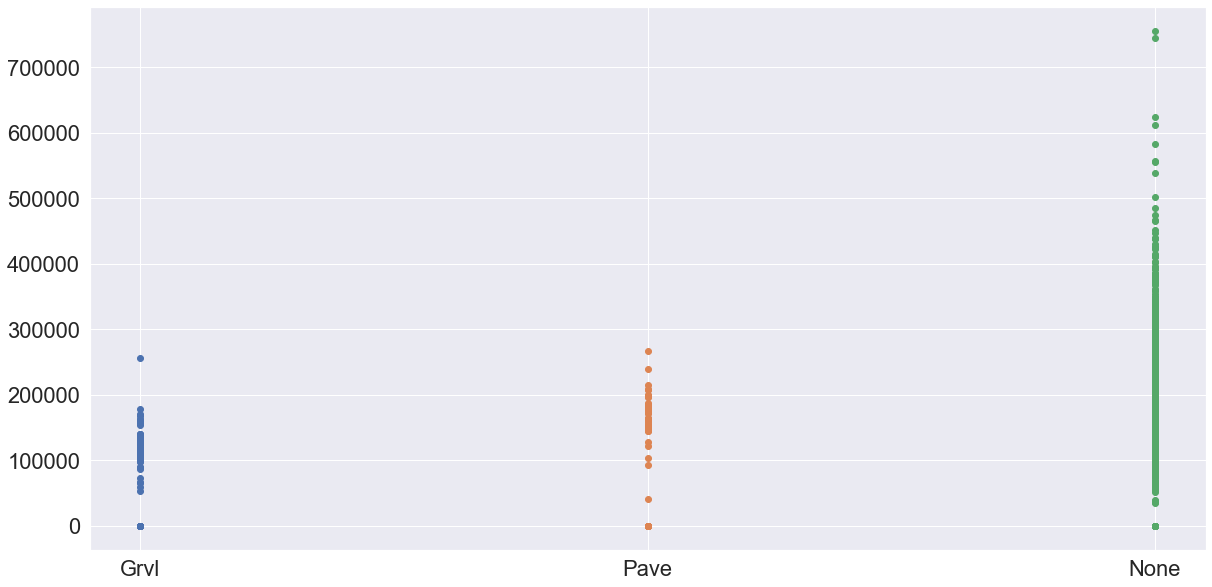

In [133]:
plt.figure(figsize=(20,10))
plt.scatter(data_train[data_train['Alley'] == 'Grvl']['Alley'],data_train[data_train['Alley'] == 'Grvl']['SalePrice'])
plt.scatter(data_train[data_train['Alley'] == 'Pave']['Alley'],data_train[data_train['Alley'] == 'Pave']['SalePrice'])
plt.scatter(data_train[data_train['Alley'].isna() == True]['Alley'].fillna(value = 'None'), data_train[data_train['Alley'].isna() == True]['SalePrice'])
plt.show()

Как можно увидеть, отсутствующий тип жилья располагается как в зоне Pave так и в зоне Grvl, таким образом мы также можем заменить данные пропущенные значения на None

In [134]:
data_train['Alley'] = data_train['Alley'].fillna(value = 'None')

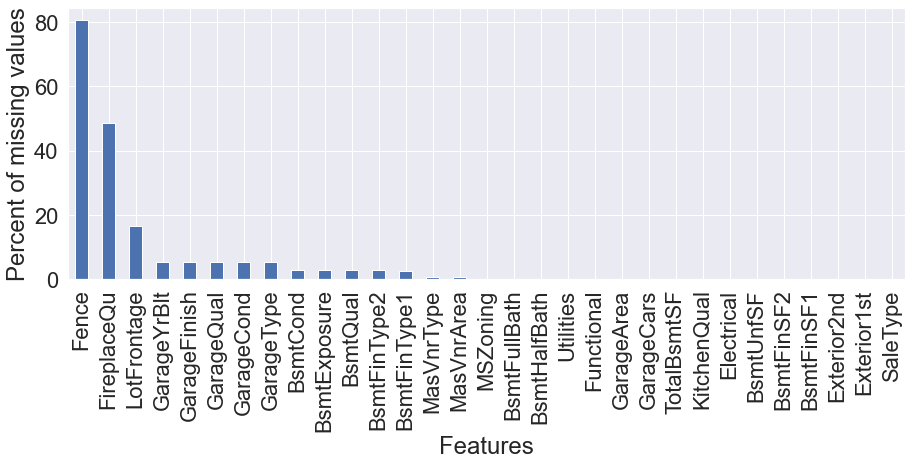

Процент пропущенных значений в столбцах
Fence           80.438506
FireplaceQu     48.646797
LotFrontage     16.649538
GarageYrBlt      5.447071
GarageFinish     5.447071
GarageQual       5.447071
GarageCond       5.447071
GarageType       5.378554
BsmtCond         2.809181
BsmtExposure     2.809181
BsmtQual         2.774923
BsmtFinType2     2.740665
BsmtFinType1     2.706406
MasVnrType       0.822199
MasVnrArea       0.787941
MSZoning         0.137033
BsmtFullBath     0.068517
BsmtHalfBath     0.068517
Utilities        0.068517
Functional       0.068517
GarageArea       0.034258
GarageCars       0.034258
TotalBsmtSF      0.034258
KitchenQual      0.034258
Electrical       0.034258
BsmtUnfSF        0.034258
BsmtFinSF2       0.034258
BsmtFinSF1       0.034258
Exterior2nd      0.034258
Exterior1st      0.034258
SaleType         0.034258
dtype: float64
------------------------------------------------
Fence object
FireplaceQu object
LotFrontage float64
GarageYrBlt float64
GarageFinish objec

In [135]:
ProcentOfMissingValue(data_train)

4. Fence Качество забора

In [136]:
data_train['Fence'].value_counts()

MnPrv    329
GdPrv    118
GdWo     112
MnWw      12
Name: Fence, dtype: int64

Мы не можем определить по имеющимся метрикам качество изгороди и ее существование, соответственно заменяем значения на None

In [137]:
data_train["Fence"] = data_train["Fence"].fillna("None")

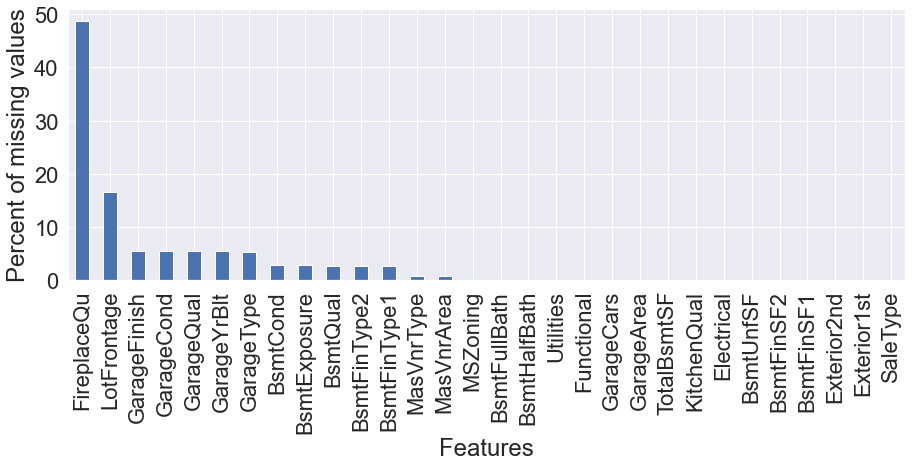

Процент пропущенных значений в столбцах
FireplaceQu     48.646797
LotFrontage     16.649538
GarageFinish     5.447071
GarageCond       5.447071
GarageQual       5.447071
GarageYrBlt      5.447071
GarageType       5.378554
BsmtCond         2.809181
BsmtExposure     2.809181
BsmtQual         2.774923
BsmtFinType2     2.740665
BsmtFinType1     2.706406
MasVnrType       0.822199
MasVnrArea       0.787941
MSZoning         0.137033
BsmtFullBath     0.068517
BsmtHalfBath     0.068517
Utilities        0.068517
Functional       0.068517
GarageCars       0.034258
GarageArea       0.034258
TotalBsmtSF      0.034258
KitchenQual      0.034258
Electrical       0.034258
BsmtUnfSF        0.034258
BsmtFinSF2       0.034258
BsmtFinSF1       0.034258
Exterior2nd      0.034258
Exterior1st      0.034258
SaleType         0.034258
dtype: float64
------------------------------------------------
FireplaceQu object
LotFrontage float64
GarageFinish object
GarageCond object
GarageQual object
GarageYrBlt float64
G

In [138]:
ProcentOfMissingValue(data_train)

5. FireplaceQu Качество камина

In [139]:
data_train[['FireplaceQu','Fireplaces']]

FireplaceQu  Fireplaces
0            NaN           0
1             TA           1
2             TA           1
3             Gd           1
4             TA           1
5            NaN           0
6             Gd           1
7             TA           2
8             TA           2
9             TA           2
10           NaN           0
11            Gd           2
12           NaN           0
13            Gd           1
14            Fa           1
15           NaN           0
16            TA           1
17           NaN           0
18           NaN           0
19           NaN           0
20            Gd           1
21            Gd           1
22            Gd           1
23            TA           1
24            TA           1
25            Gd           1
26           NaN           0
27            Gd           1
28            Gd           2
29           NaN           0
30           NaN           0
31           NaN           0
32           NaN           0
33            Gd           1
34            Gd           1
35            Gd           1
36           NaN           0
37            TA           1
38           NaN           0
39           NaN           0
40            TA           1
41            Gd           2
42           NaN           0
43           NaN           0
44           NaN           0
45            Gd           1
46            Ex           1
47           NaN           0
48           NaN           0
49           NaN           0
50           NaN           0
51            Gd           1
52           NaN           0
53            Gd           1
54            TA           1
55            Gd           1
56           NaN           0
57           NaN           0
58            Gd           1
59           NaN           0
60           NaN           0
61           NaN           0
62            Gd           1
63           NaN           0
64           NaN           0
65            Gd           1
66            Gd           1
67           NaN           0
68           NaN           0
69            TA           1
70            Gd           2
71           NaN           0
72            TA           1
73           NaN           0
74           NaN           0
75           NaN           0
76           NaN           0
77           NaN           0
78           NaN           0
79           NaN           0
80            Gd           1
81           NaN           0
82            Gd           1
83           NaN           0
84            TA           1
85            TA           1
86            Gd           1
87           NaN           0
88           NaN           0
89           NaN           0
90           NaN           0
91           NaN           0
92           NaN           0
93            Gd           1
94           NaN           0
95            TA           1
96           NaN           0
97           NaN           0
98           NaN           0
99           NaN           0
100           TA           2
101           TA           1
102          NaN           0
103          NaN           0
104           TA           2
105           Gd           1
106          NaN           0
107          NaN           0
108          NaN           0
109           TA           1
110          NaN           0
111           TA           1
112           Gd           1
113           Gd           2
114           TA           1
115           Fa           1
116           Po           1
117          NaN           0
118           TA           2
119           Gd           1
120           TA           2
121          NaN           0
122          NaN           0
123          NaN           0
124           TA           1
125          NaN           0
126           TA           1
127           TA           1
128           Fa           1
129          NaN           0
130           Gd           2
131           TA           1
132          NaN           0
133          NaN           0
134           TA           1
135           Gd           1
136           Fa           1
137

FireplaceQu: Fireplace quality

       Ex	Excellent - Exceptional Masonry Fireplace
       Gd	Good - Masonry Fireplace in main level
       TA	Average - Prefabricated Fireplace in main living area or Masonry Fireplace in basement
       Fa	Fair - Prefabricated Fireplace in basement
       Po	Poor - Ben Franklin Stove
       NA	No Fireplace

Как можно понять из описания к данной переменной, если отсутствуют значения качества, то отсутствует камин, соответственном мы можем заменить на None

In [140]:
data_train["FireplaceQu"] = data_train["FireplaceQu"].fillna("None")

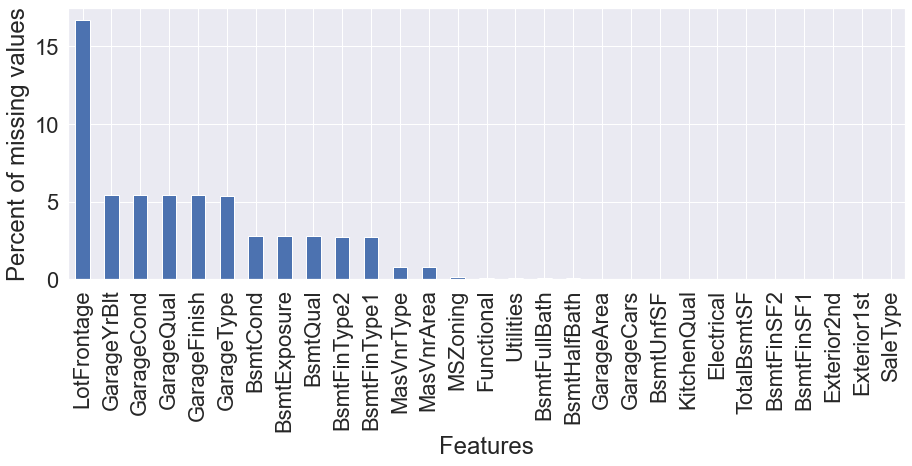

Процент пропущенных значений в столбцах
LotFrontage     16.649538
GarageYrBlt      5.447071
GarageCond       5.447071
GarageQual       5.447071
GarageFinish     5.447071
GarageType       5.378554
BsmtCond         2.809181
BsmtExposure     2.809181
BsmtQual         2.774923
BsmtFinType2     2.740665
BsmtFinType1     2.706406
MasVnrType       0.822199
MasVnrArea       0.787941
MSZoning         0.137033
Functional       0.068517
Utilities        0.068517
BsmtFullBath     0.068517
BsmtHalfBath     0.068517
GarageArea       0.034258
GarageCars       0.034258
BsmtUnfSF        0.034258
KitchenQual      0.034258
Electrical       0.034258
TotalBsmtSF      0.034258
BsmtFinSF2       0.034258
BsmtFinSF1       0.034258
Exterior2nd      0.034258
Exterior1st      0.034258
SaleType         0.034258
dtype: float64
------------------------------------------------
LotFrontage float64
GarageYrBlt float64
GarageCond object
GarageQual object
GarageFinish object
GarageType object
BsmtCond object
BsmtExposure

In [141]:
ProcentOfMissingValue(data_train)

6. LotFrontage Линейные футы улицы, соединенной с недвижимостью

In [142]:
data_train['LotFrontage'].isna().sum()

486

Данная переменная имеет 259 пропущенных значений

In [143]:
data_train['LotFrontage'].head(5)

0    65.0
1    80.0
2    68.0
3    60.0
4    84.0
Name: LotFrontage, dtype: float64

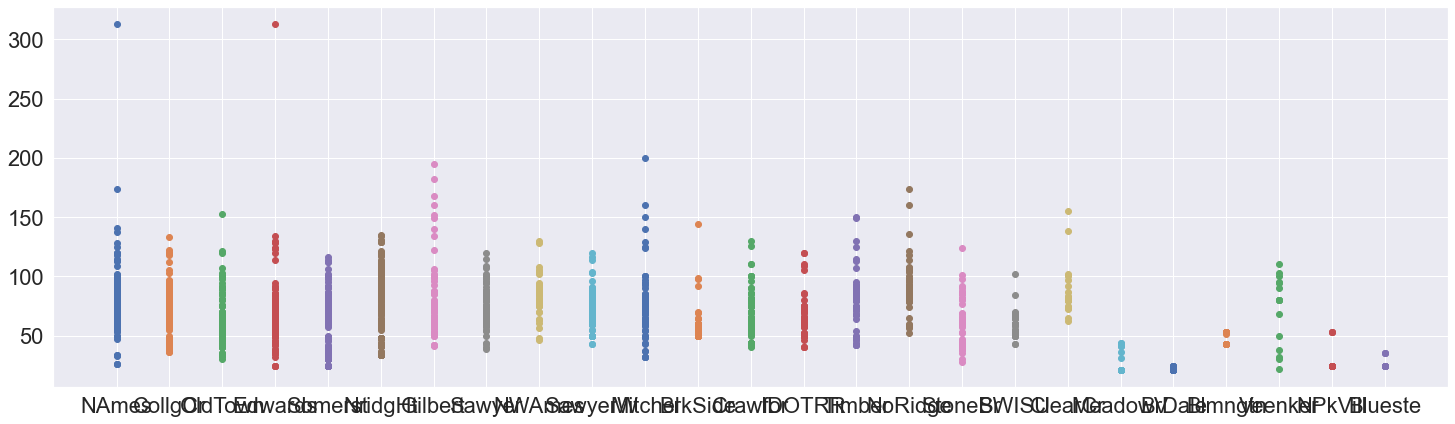

In [144]:
plt.figure(figsize=(25,7))
for i in data_train['Neighborhood'].value_counts().index:
    plt.scatter(data_train[data_train['Neighborhood'] == i]['Neighborhood'],data_train[data_train['Neighborhood'] == i]['LotFrontage'])
plt.show()
# plt.scatter(data_train[data_train['Neighborhood'] == 'NAmes']['Neighborhood'],data_train[data_train['Neighborhood'] == 'NAmes']['LotFrontage'])

Заполним средними значениями пропущенные значения в поле LotFrontage

In [145]:
data_train['Neighborhood'].value_counts().index

Index(['NAmes', 'CollgCr', 'OldTown', 'Edwards', 'Somerst', 'NridgHt',
       'Gilbert', 'Sawyer', 'NWAmes', 'SawyerW', 'Mitchel', 'BrkSide',
       'Crawfor', 'IDOTRR', 'Timber', 'NoRidge', 'StoneBr', 'SWISU', 'ClearCr',
       'MeadowV', 'BrDale', 'Blmngtn', 'Veenker', 'NPkVill', 'Blueste'],
      dtype='object')

In [146]:
data_train['LotFrontage'].isna().sum()

486

In [147]:
for i in data_train['Neighborhood'].value_counts().index:
    data_train.loc[data_train[data_train['Neighborhood'] == i][data_train['LotFrontage'].isna() == True]['LotFrontage'].index, 'LotFrontage'] = data_train[data_train['Neighborhood'] == i]['LotFrontage'].median()

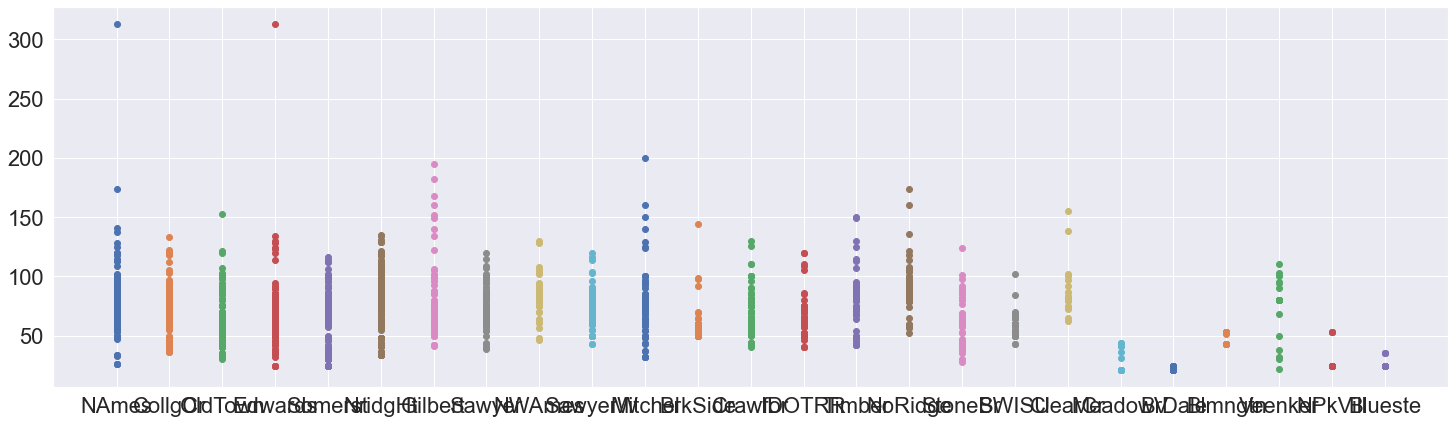

0

In [148]:
plt.figure(figsize=(25,7))
for i in data_train['Neighborhood'].value_counts().index:
    plt.scatter(data_train[data_train['Neighborhood'] == i]['Neighborhood'],data_train[data_train['Neighborhood'] == i]['LotFrontage'])
plt.show()
data_train['LotFrontage'].isna().sum()

In [149]:
data_train['LotFrontage'].head(5)

0    65.0
1    80.0
2    68.0
3    60.0
4    84.0
Name: LotFrontage, dtype: float64

Как можно наблюдать, пропущенные данные заполнены

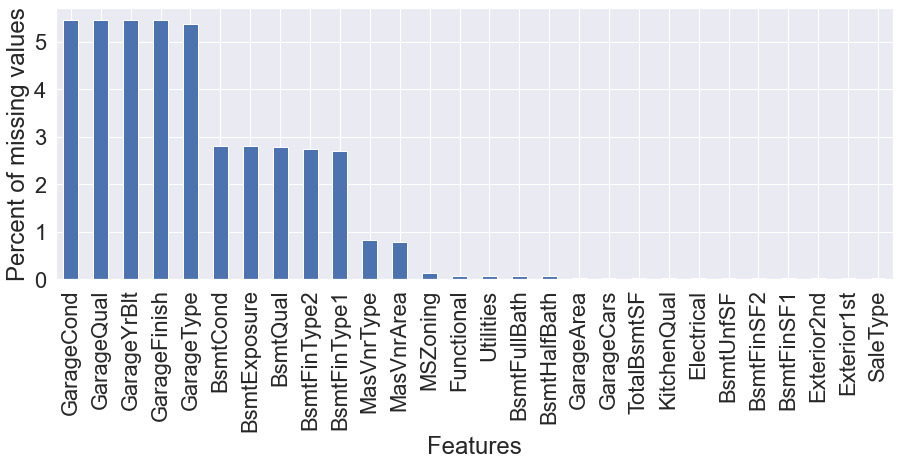

Процент пропущенных значений в столбцах
GarageCond      5.447071
GarageQual      5.447071
GarageYrBlt     5.447071
GarageFinish    5.447071
GarageType      5.378554
BsmtCond        2.809181
BsmtExposure    2.809181
BsmtQual        2.774923
BsmtFinType2    2.740665
BsmtFinType1    2.706406
MasVnrType      0.822199
MasVnrArea      0.787941
MSZoning        0.137033
Functional      0.068517
Utilities       0.068517
BsmtFullBath    0.068517
BsmtHalfBath    0.068517
GarageArea      0.034258
GarageCars      0.034258
TotalBsmtSF     0.034258
KitchenQual     0.034258
Electrical      0.034258
BsmtUnfSF       0.034258
BsmtFinSF2      0.034258
BsmtFinSF1      0.034258
Exterior2nd     0.034258
Exterior1st     0.034258
SaleType        0.034258
dtype: float64
------------------------------------------------
GarageCond object
GarageQual object
GarageYrBlt float64
GarageFinish object
GarageType object
BsmtCond object
BsmtExposure object
BsmtQual object
BsmtFinType2 object
BsmtFinType1 object
MasVnrType

In [150]:
ProcentOfMissingValue(data_train)

7.  GarageType      Место в гараже

    GarageYrBlt     Год постройки гаража.

    GarageFinish    Внутренняя отделка гаража

    GarageQual      качество гаража

    GarageCond      Состояние гаража

Для анализа можно использовать еще две переменных

    GarageCars: Размер гаража по вместимости автомобиля

    GarageArea: Размер гаража в квадратных футах.

In [151]:
# data_train.loc[data_train[data_train['GarageCond'].isna() == True].index][['GarageType','GarageYrBlt','GarageFinish','GarageQual','GarageCond','GarageCars','GarageArea']]

Можно увидеть, что переменная GarageArea == 0 тогда другие значения == NaN

In [152]:
data_train['GarageType'].dtype

dtype('O')

In [153]:
data_train['GarageType'] = data_train['GarageType'].fillna('None')

In [154]:
data_train['GarageYrBlt'] = data_train['GarageYrBlt'].fillna(0)

In [155]:
data_train['GarageFinish'] = data_train['GarageFinish'].fillna('None')

In [156]:
data_train['GarageQual'] = data_train['GarageQual'].fillna('None')

In [157]:
data_train['GarageCond'] = data_train['GarageCond'].fillna('None')

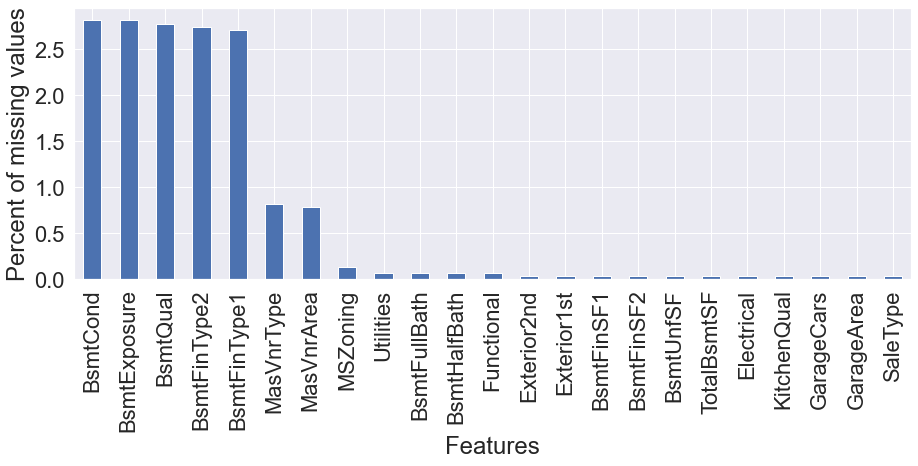

Процент пропущенных значений в столбцах
BsmtCond        2.809181
BsmtExposure    2.809181
BsmtQual        2.774923
BsmtFinType2    2.740665
BsmtFinType1    2.706406
MasVnrType      0.822199
MasVnrArea      0.787941
MSZoning        0.137033
Utilities       0.068517
BsmtFullBath    0.068517
BsmtHalfBath    0.068517
Functional      0.068517
Exterior2nd     0.034258
Exterior1st     0.034258
BsmtFinSF1      0.034258
BsmtFinSF2      0.034258
BsmtUnfSF       0.034258
TotalBsmtSF     0.034258
Electrical      0.034258
KitchenQual     0.034258
GarageCars      0.034258
GarageArea      0.034258
SaleType        0.034258
dtype: float64
------------------------------------------------
BsmtCond object
BsmtExposure object
BsmtQual object
BsmtFinType2 object
BsmtFinType1 object
MasVnrType object
MasVnrArea float64
MSZoning object
Utilities object
BsmtFullBath float64
BsmtHalfBath float64
Functional object
Exterior2nd object
Exterior1st object
BsmtFinSF1 float64
BsmtFinSF2 float64
BsmtUnfSF float64
Total

In [158]:
ProcentOfMissingValue(data_train)

    8.BsmtExposure Стены подвала на уровне выхода или сада.
    BsmtFinType2   Качество второй обработанной области (если присутствует)

Все значения имеющие связи с подвалом:

    BsmtQual: Высота подвала
    
    
    BsmtCond: Общее состояние подвала
    
    
    TotalBsmtSF: Общая площадь подвала в квадратных футах.
    
    
    BsmtFullBath: Ванные комнаты в подвале
    
    
    BsmtHalfBath: Половина ванных комнат в подвале
    
    

Выведим пропущенные значения и значения которые имеют связь с пропущенными значениями

In [159]:
# data_train.loc[data_train[data_train['BsmtExposure'].isna() == True].index][['BsmtExposure','BsmtFinType2','BsmtQual','BsmtCond','TotalBsmtSF','BsmtFullBath','BsmtHalfBath']]

Как можно видеть, практически все значения можно заполнить значениями None в связи с отсутствием подвального помещения, кроме индекса 948

Значения под индексом 948 можно заполнить изучив значения столбцов

In [160]:
data_train[(data_train['BsmtFinType2'] == 'Unf') & (data_train['BsmtQual'] == 'Gd') & (data_train['BsmtCond'] == 'TA') & (data_train['TotalBsmtSF'] > 900) & (data_train['TotalBsmtSF'] < 1000)][['BsmtExposure']].value_counts()


BsmtExposure
No              81
Av              17
Gd              12
Mn              11
dtype: int64

Были настроены фильтры по значениям (data_train['BsmtFinType2'] == 'Unf') & (data_train['BsmtQual'] == 'Gd') & (data_train['BsmtCond'] == 'TA') & (data_train['TotalBsmtSF'] > 900) & (data_train['TotalBsmtSF'] < 1000), и мы получили что наибольшая вероятность попадания значения с этими характеристиками в значение 'No'

In [161]:
data_train.loc[948,'BsmtExposure'] = 'No'

Еще раз провряем значения 

In [162]:
# data_train.loc[data_train[data_train['BsmtExposure'].isna() == True].index][['BsmtExposure','BsmtFinType2','BsmtQual','BsmtCond','TotalBsmtSF','BsmtFullBath','BsmtHalfBath']]

Как можно видеть, значение под индексом 948 пропало

Остальыне значения можно заполнить None

In [163]:
index_ = data_train.loc[data_train[data_train['BsmtExposure'].isna() == True].index][['BsmtExposure','BsmtFinType2']].index
rows_ = ['BsmtExposure', 'BsmtFinType2']
data_train.loc[index_, rows_] = data_train.loc[index_, rows_].fillna('None')

In [164]:
data_train.loc[data_train[data_train['BsmtExposure'].isna() == True].index][['BsmtExposure','BsmtFinType2']]

Empty DataFrame
Columns: [BsmtExposure, BsmtFinType2]
Index: []

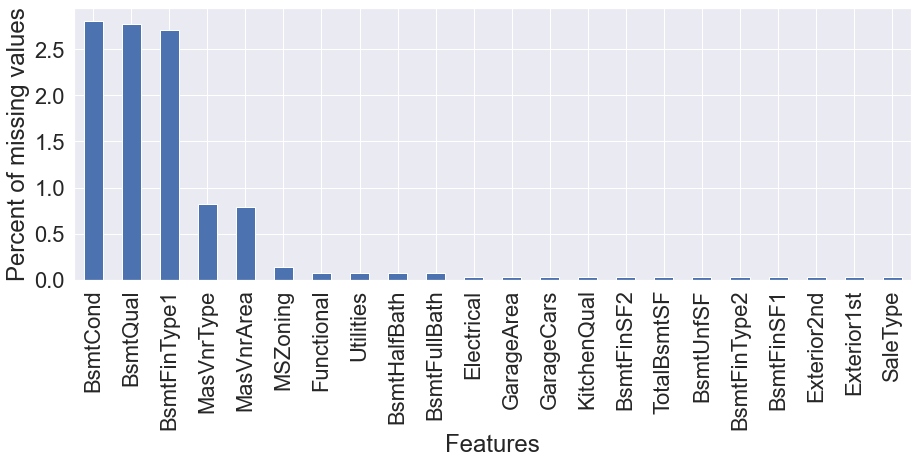

Процент пропущенных значений в столбцах
BsmtCond        2.809181
BsmtQual        2.774923
BsmtFinType1    2.706406
MasVnrType      0.822199
MasVnrArea      0.787941
MSZoning        0.137033
Functional      0.068517
Utilities       0.068517
BsmtHalfBath    0.068517
BsmtFullBath    0.068517
Electrical      0.034258
GarageArea      0.034258
GarageCars      0.034258
KitchenQual     0.034258
BsmtFinSF2      0.034258
TotalBsmtSF     0.034258
BsmtUnfSF       0.034258
BsmtFinType2    0.034258
BsmtFinSF1      0.034258
Exterior2nd     0.034258
Exterior1st     0.034258
SaleType        0.034258
dtype: float64
------------------------------------------------
BsmtCond object
BsmtQual object
BsmtFinType1 object
MasVnrType object
MasVnrArea float64
MSZoning object
Functional object
Utilities object
BsmtHalfBath float64
BsmtFullBath float64
Electrical object
GarageArea float64
GarageCars float64
KitchenQual object
BsmtFinSF2 float64
TotalBsmtSF float64
BsmtUnfSF float64
BsmtFinType2 object
BsmtFinSF1 f

In [165]:
ProcentOfMissingValue(data_train)

    9. BsmtQual Высота подвала
    
       BsmtCond Общее состояние подвала
    
       BsmtFinType1 Качество отделки цокольного этажа

In [166]:
data_train.loc[data_train[(data_train['BsmtQual'].isna() == True) & (data_train['BsmtCond'].isna() == True) & (data_train['BsmtFinType1'].isna() == True)].index][['BsmtExposure','BsmtFinType2','BsmtQual','BsmtCond', 'BsmtFinType1','TotalBsmtSF','BsmtFullBath','BsmtHalfBath']]

BsmtExposure BsmtFinType2 BsmtQual BsmtCond BsmtFinType1  TotalBsmtSF  \
17           None         None      NaN      NaN          NaN          0.0   
39           None         None      NaN      NaN          NaN          0.0   
90           None         None      NaN      NaN          NaN          0.0   
102          None         None      NaN      NaN          NaN          0.0   
156          None         None      NaN      NaN          NaN          0.0   
182          None         None      NaN      NaN          NaN          0.0   
259          None         None      NaN      NaN          NaN          0.0   
342          None         None      NaN      NaN          NaN          0.0   
362          None         None      NaN      NaN          NaN          0.0   
371          None         None      NaN      NaN          NaN          0.0   
392          None         None      NaN      NaN          NaN          0.0   
520          None         None      NaN      NaN          NaN          0.0   
532          None         None      NaN      NaN          NaN          0.0   
533          None         None      NaN      NaN          NaN          0.0   
553          None         None      NaN      NaN          NaN          0.0   
646          None         None      NaN      NaN          NaN          0.0   
705          None         None      NaN      NaN          NaN          0.0   
736          None         None      NaN      NaN          NaN          0.0   
749          None         None      NaN      NaN          NaN          0.0   
778          None         None      NaN      NaN          NaN          0.0   
868          None         None      NaN      NaN          NaN          0.0   
894          None         None      NaN      NaN          NaN          0.0   
897          None         None      NaN      NaN          NaN          0.0   
984          None         None      NaN      NaN          NaN          0.0   
1000         None         None      NaN      NaN          NaN          0.0   
1011         None         None      NaN      NaN          NaN          0.0   
1035         None         None      NaN      NaN          NaN          0.0   
1045         None         None      NaN      NaN          NaN          0.0   
1048         None         None      NaN      NaN          NaN          0.0   
1049         None         None      NaN      NaN          NaN          0.0   
1090         None         None      NaN      NaN          NaN          0.0   
1179         None         None      NaN      NaN          NaN          0.0   
1216         None         None      NaN      NaN          NaN          0.0   
1218         None         None      NaN      NaN          NaN          0.0   
1232         None         None      NaN      NaN          NaN          0.0   
1321         None         None      NaN      NaN          NaN          0.0   
1412         None         None      NaN      NaN          NaN          0.0   
1585         None         None      NaN      NaN          NaN          0.0   
1593         None         None      NaN      NaN          NaN          0.0   
1729         None         None      NaN      NaN          NaN          0.0   
1778         None         None      NaN      NaN          NaN          0.0   
1814         None         None      NaN      NaN          NaN          0.0   
1847         None         None      NaN      NaN          NaN          0.0   
1848         None         None      NaN      NaN          NaN          0.0   
1856         None         None      NaN      NaN          NaN          0.0   
1857         None         None      NaN      NaN          NaN          0.0   
1858         None         None      NaN      NaN          NaN          0.0   
1860         None         None      NaN      NaN          NaN          0.0   
1915         None         None      NaN      NaN          NaN          0.0   
2050         None         None      NaN      NaN          NaN          0.0   
2066         None         N

Как можно видеть, все значения можно заменить на None

In [167]:
index_ = data_train.loc[data_train[(data_train['BsmtQual'].isna() == True) & (data_train['BsmtCond'].isna() == True) & (data_train['BsmtFinType1'].isna() == True)].index].index
rows_ = ['BsmtQual', 'BsmtCond','BsmtFinType1']
data_train.loc[index_, rows_] = data_train.loc[index_, rows_].fillna('None')

In [168]:
data_train.loc[data_train[(data_train['BsmtQual'].isna() == True) & (data_train['BsmtCond'].isna() == True) & (data_train['BsmtFinType1'].isna() == True)].index][['BsmtExposure','BsmtFinType2','BsmtQual','BsmtCond', 'BsmtFinType1','TotalBsmtSF','BsmtFullBath','BsmtHalfBath']]

Empty DataFrame
Columns: [BsmtExposure, BsmtFinType2, BsmtQual, BsmtCond, BsmtFinType1, TotalBsmtSF, BsmtFullBath, BsmtHalfBath]
Index: []

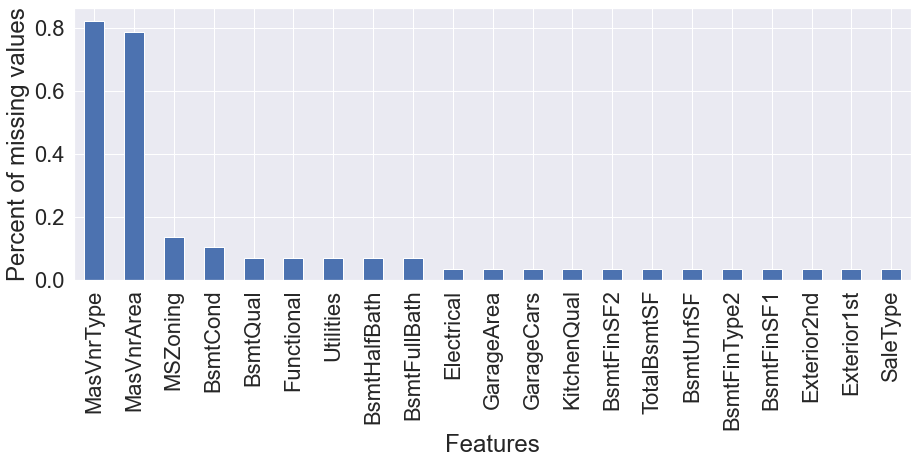

Процент пропущенных значений в столбцах
MasVnrType      0.822199
MasVnrArea      0.787941
MSZoning        0.137033
BsmtCond        0.102775
BsmtQual        0.068517
Functional      0.068517
Utilities       0.068517
BsmtHalfBath    0.068517
BsmtFullBath    0.068517
Electrical      0.034258
GarageArea      0.034258
GarageCars      0.034258
KitchenQual     0.034258
BsmtFinSF2      0.034258
TotalBsmtSF     0.034258
BsmtUnfSF       0.034258
BsmtFinType2    0.034258
BsmtFinSF1      0.034258
Exterior2nd     0.034258
Exterior1st     0.034258
SaleType        0.034258
dtype: float64
------------------------------------------------
MasVnrType object
MasVnrArea float64
MSZoning object
BsmtCond object
BsmtQual object
Functional object
Utilities object
BsmtHalfBath float64
BsmtFullBath float64
Electrical object
GarageArea float64
GarageCars float64
KitchenQual object
BsmtFinSF2 float64
TotalBsmtSF float64
BsmtUnfSF float64
BsmtFinType2 object
BsmtFinSF1 float64
Exterior2nd object
Exterior1st object


In [169]:
ProcentOfMissingValue(data_train)

    10. MasVnrType Тип каменной кладки
        MasVnrArea Площадь каменной кладки в квадратных футах.

In [170]:
index_ = data_train.loc[data_train[(data_train['MasVnrType'].isna() == True) & (data_train['MasVnrArea'].isna() == True)].index][['MasVnrType','MasVnrArea']].index
rows_ = ['MasVnrType']
data_train.loc[index_, rows_] = data_train.loc[index_, rows_].fillna('None')

In [171]:
data_train['MasVnrType'].value_counts()

None       1765
BrkFace     879
Stone       249
BrkCmn       25
Name: MasVnrType, dtype: int64

In [172]:
index_ = data_train.loc[data_train[(data_train['MasVnrArea'].isna() == True)].index][['MasVnrArea']].index
rows_ = ['MasVnrArea']
data_train.loc[index_, rows_] = data_train.loc[index_, rows_].fillna(0)

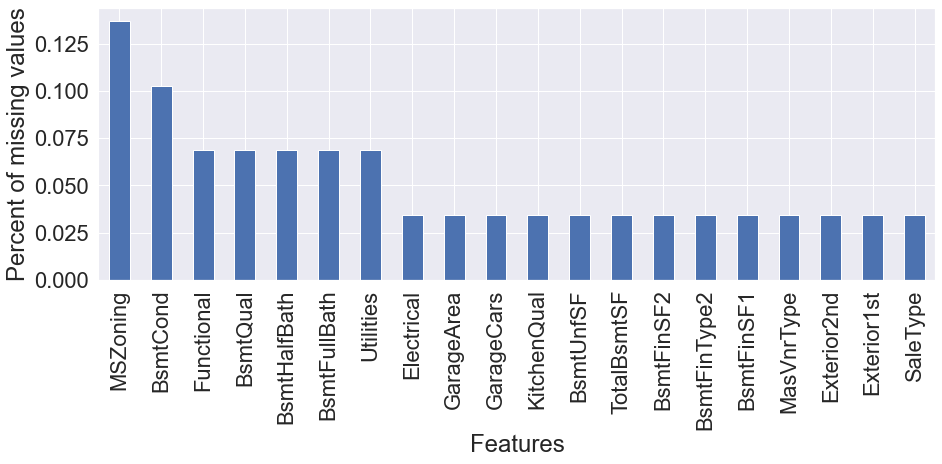

Процент пропущенных значений в столбцах
MSZoning        0.137033
BsmtCond        0.102775
Functional      0.068517
BsmtQual        0.068517
BsmtHalfBath    0.068517
BsmtFullBath    0.068517
Utilities       0.068517
Electrical      0.034258
GarageArea      0.034258
GarageCars      0.034258
KitchenQual     0.034258
BsmtUnfSF       0.034258
TotalBsmtSF     0.034258
BsmtFinSF2      0.034258
BsmtFinType2    0.034258
BsmtFinSF1      0.034258
MasVnrType      0.034258
Exterior2nd     0.034258
Exterior1st     0.034258
SaleType        0.034258
dtype: float64
------------------------------------------------
MSZoning object
BsmtCond object
Functional object
BsmtQual object
BsmtHalfBath float64
BsmtFullBath float64
Utilities object
Electrical object
GarageArea float64
GarageCars float64
KitchenQual object
BsmtUnfSF float64
TotalBsmtSF float64
BsmtFinSF2 float64
BsmtFinType2 object
BsmtFinSF1 float64
MasVnrType object
Exterior2nd object
Exterior1st object
SaleType object


In [173]:
ProcentOfMissingValue(data_train)

    11. BsmtFinType2 Качество второй обработанной области (если присутствует)
    Electrical Электрическая система

In [174]:
data_train.loc[data_train[(data_train['BsmtFinType2'].isna() == True)|(data_train['Electrical'].isna() == True)].index][['BsmtFinType2','Electrical']]
# data_train[['BsmtFinType2','Electrical']]

BsmtFinType2 Electrical
332           NaN      SBrkr
1379          Unf        NaN

In [175]:
data_train[data_train['BsmtFinType2'] == 'Unf'][['BsmtFinType2','Electrical']].value_counts()

BsmtFinType2  Electrical
Unf           SBrkr         2288
              FuseA          157
              FuseF           39
              FuseP            7
              Mix              1
dtype: int64

In [176]:
index_ = data_train.loc[data_train[(data_train['Electrical'].isna() == True)].index][['Electrical']].index
print(index_)
rows_ = ['Electrical']
data_train.loc[index_, rows_] = data_train.loc[index_, rows_].fillna('SBrkr')

Int64Index([1379], dtype='int64')


In [177]:
data_train.loc[1379,'Electrical']

'SBrkr'

In [178]:
data_train[data_train['Electrical'] == 'SBrkr'][['BsmtFinType2','Electrical']].value_counts()

BsmtFinType2  Electrical
Unf           SBrkr         2289
Rec           SBrkr           97
LwQ           SBrkr           83
BLQ           SBrkr           64
None          SBrkr           55
ALQ           SBrkr           49
GLQ           SBrkr           34
dtype: int64

In [179]:
index_ = data_train.loc[data_train[(data_train['BsmtFinType2'].isna() == True)].index][['BsmtFinType2']].index
print(index_)
rows_ = ['BsmtFinType2']
data_train.loc[index_, rows_] = data_train.loc[index_, rows_].fillna('Unf')

Int64Index([332], dtype='int64')


In [180]:
data_train.loc[332,'BsmtFinType2']

'Unf'

Проверяем на наличие пропущенных значений

In [181]:
data_train.isna().sum().sum()

28

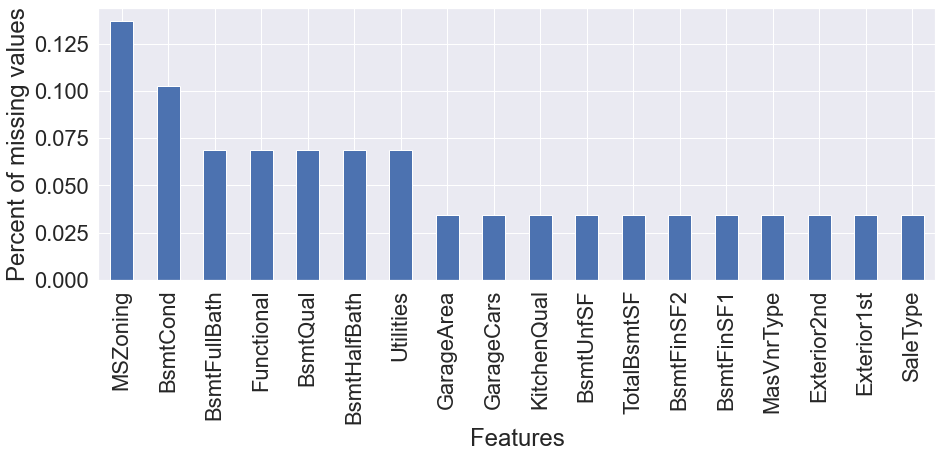

Процент пропущенных значений в столбцах
MSZoning        0.137033
BsmtCond        0.102775
BsmtFullBath    0.068517
Functional      0.068517
BsmtQual        0.068517
BsmtHalfBath    0.068517
Utilities       0.068517
GarageArea      0.034258
GarageCars      0.034258
KitchenQual     0.034258
BsmtUnfSF       0.034258
TotalBsmtSF     0.034258
BsmtFinSF2      0.034258
BsmtFinSF1      0.034258
MasVnrType      0.034258
Exterior2nd     0.034258
Exterior1st     0.034258
SaleType        0.034258
dtype: float64
------------------------------------------------
MSZoning object
BsmtCond object
BsmtFullBath float64
Functional object
BsmtQual object
BsmtHalfBath float64
Utilities object
GarageArea float64
GarageCars float64
KitchenQual object
BsmtUnfSF float64
TotalBsmtSF float64
BsmtFinSF2 float64
BsmtFinSF1 float64
MasVnrType object
Exterior2nd object
Exterior1st object
SaleType object


In [182]:
ProcentOfMissingValue(data_train)

In [183]:
data_train[['MSZoning', 'BsmtCond', 'Functional', 'BsmtQual', 'Utilities', 'KitchenQual', 'MasVnrType', 'Exterior2nd', 'Exterior1st', 'SaleType']] = data_train[['MSZoning', 'BsmtCond', 'Functional', 'BsmtQual', 'Utilities', 'KitchenQual', 'MasVnrType', 'Exterior2nd', 'Exterior1st', 'SaleType']].fillna('None')

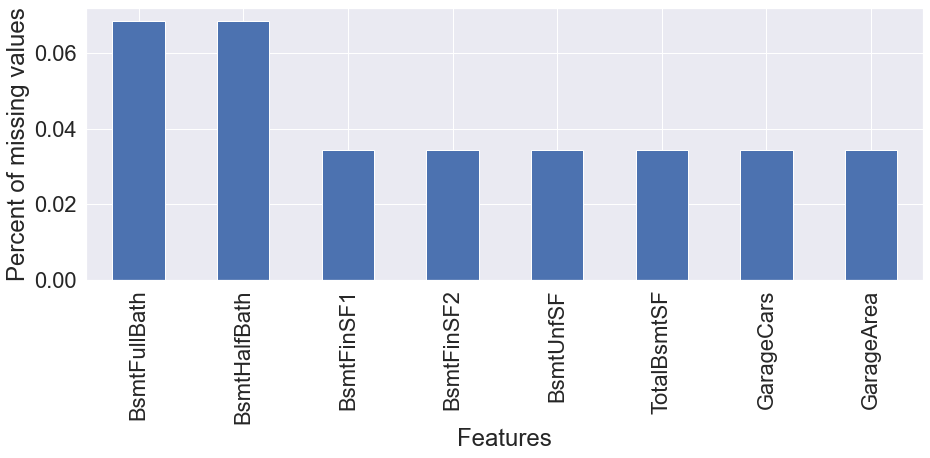

Процент пропущенных значений в столбцах
BsmtFullBath    0.068517
BsmtHalfBath    0.068517
BsmtFinSF1      0.034258
BsmtFinSF2      0.034258
BsmtUnfSF       0.034258
TotalBsmtSF     0.034258
GarageCars      0.034258
GarageArea      0.034258
dtype: float64
------------------------------------------------
BsmtFullBath float64
BsmtHalfBath float64
BsmtFinSF1 float64
BsmtFinSF2 float64
BsmtUnfSF float64
TotalBsmtSF float64
GarageCars float64
GarageArea float64


In [184]:
ProcentOfMissingValue(data_train)

In [185]:
data_train[['BsmtFullBath', 'BsmtHalfBath', 'BsmtFinSF1', 'BsmtFinSF2', 'BsmtUnfSF', 'TotalBsmtSF', 'GarageCars', 'GarageArea']] = data_train[['BsmtFullBath', 'BsmtHalfBath', 'BsmtFinSF1', 'BsmtFinSF2', 'BsmtUnfSF', 'TotalBsmtSF', 'GarageCars', 'GarageArea']].fillna(0)

In [186]:
data_train.isna().sum().sum()

0

Мы получили чистый датасет, без пропущенных значений

**Описание наименований столбцов**
- SalePrice: цена продажи недвижимости в долларах. Это целевая переменная, которую вы пытаетесь предсказать.
- MSSubClass: класс здания
- MSZoning: Общая классификация зонирования
- LotFrontage: Линейные футы улицы, соединенной с недвижимостью
- LotArea: Размер участка в квадратных футах.
- Улица: Тип подъездной дороги
- Аллея: Тип доступа к аллее
- LotShape: Общий вид недвижимости
- LandContour: Плоскостность объекта
- Утилиты: Тип доступных утилит
- LotConfig: конфигурация лота
- LandSlope: уклон участка
- Окрестности: физические местоположения в черте города Эймс.
- Условие 1: Близость к главной дороге или железной дороге
- Условие 2: близость к главной дороге или железной дороге (при наличии второй)
- BldgType: Тип жилья
- HouseStyle: стиль жилья
- Общее качество: общее качество материала и отделки.
- TotalCond: общая оценка состояния
- Год постройки: Первоначальная дата постройки
- YearRemodAdd: дата переделки
- RoofStyle: тип крыши
- RoofMatl: Материал крыши
- Exterior1st: Внешнее покрытие дома
- Exterior2nd: Внешнее покрытие дома (если более одного материала)
- MasVnrType: Тип каменной кладки
- MasVnrArea: Площадь каменной кладки в квадратных футах.
- ExterQual: качество материалов экстерьера
- ExterCond: Текущее состояние материала снаружи.
- Фундамент: Тип фундамента
- BsmtQual: Высота подвала
- BsmtCond: Общее состояние подвала
- BsmtExposure: Стены подвала на уровне выхода или сада.
- BsmtFinType1: Качество отделки цокольного этажа
- BsmtFinSF1: тип 1 с отделкой в квадратных футах
- BsmtFinType2: Качество второй обработанной области (если присутствует)
- BsmtFinSF2: тип 2 с отделкой в квадратных футах
- BsmtUnfSF: Незавершенные квадратные футы цокольного этажа.
- TotalBsmtSF: Общая площадь подвала в квадратных футах.
- Отопление: Тип отопления
- ОтоплениеQC: Качество и состояние отопления
- CentralAir: центральное кондиционирование
- Электрика: Электрическая система
- 1stFlrSF: квадратные футы первого этажа
- 2ndFlrSF: Квадратные футы второго этажа.
- LowQualFinSF: квадратные футы с отделкой низкого качества (все этажи)
- GrLivArea: жилая площадь над землей в квадратных футах
- BsmtFullBath: Ванные комнаты в подвале
- BsmtHalfBath: Половина ванных комнат в подвале
- FullBath: полностью оборудованные ванные комнаты выше уровня земли.
- HalfBath: полуванны выше уровня
- Спальня: Количество спален выше цокольного этажа
- Кухня: Количество кухонь
- KitchenQual: Качество кухни
- TotRmsAbvGrd: Общее количество комнат выше класса (не включая ванные комнаты)
- Функциональность: рейтинг домашней функциональности
- Камины: Количество каминов
- FireplaceQu: качество камина
- GarageType: Место в гараже
- GarageYrBlt: Год постройки гаража.
- GarageFinish: Внутренняя отделка гаража
- GarageCars: Размер гаража по вместимости автомобиля
- GarageArea: Размер гаража в квадратных футах.
- GarageQual: качество гаража
- GarageCond: Гаражное состояние
- PavedDrive: Асфальтированная дорога
- WoodDeckSF: площадь деревянной палубы в квадратных футах.
- OpenPorchSF: площадь открытого крыльца в квадратных футах.
- EnclosedPorch: закрытая площадь крыльца в квадратных футах.
- 3SsnPorch: площадь крыльца для трех сезонов в квадратных футах.
- ScreenPorch: Площадь крыльца в квадратных футах.
- PoolArea: Площадь бассейна в квадратных футах.
- PoolQC: качество пула
- Забор: Качество забора
- MiscFeature: Разная функция, не включенная в другие категории.
- MiscVal: Значение различных функций
- MoSold: месяц продажи
- Год продажи: Год продажи
- SaleType: Тип продажи
- Состояние продажи: Состояние продажи

**Преобразование катигориальных данных в цифровые**

В связи с тем, что имы имеем катигориальные данные, а нейронные сети работают с цифрами, необходимо произвести их преобразование

In [187]:
# ctr = 0
# for i in data_train.dtypes[data_train.dtypes == 'O'].index:
#     ctr = ctr + len(data_train[i].value_counts().index)
# print('После преобразования мы должны получить количество столбцов: ', len(data_train.columns) - len(data_train.dtypes[data_train.dtypes == 'O'].index) + ctr)
# # Функция преобразования категориальных значений в цифровые
# def ConvertCatToNum(data):
#     data_ = data
#     if(data.dtypes[data.dtypes == 'O'].count() == 0):
#         return data
#     if(data.dtypes[data.dtypes == 'O'].count() > 0):
#         index = data.dtypes[data.dtypes == 'O'].index.tolist()
#         for i in index:
# #             futurs = 
# #             futurs = pd.get_dummies(data[i]).reset_index(drop=True)
#             data_ = pd.concat([data_,
#                    pd.get_dummies(data_[i], prefix = i).reset_index(drop=True)],
#                   axis = 1)
#             data_ = data_.drop(i,axis=1)
#         return data_
# data_train = ConvertCatToNum(data_train)

На выходе мы получаем преобразованные катигориальные данные, добавленные к существующему датфрейму и удаленные столбцы катигориальных данных.
Разбиение данных с использованием **get_dummies** не дает гибкости во время обучения, в процерочном датасете могут отсутствовать строки

In [188]:
cat_dat = {}
data_train.dtypes[data_train.dtypes == 'O'].index

Index(['MSZoning', 'Street', 'Alley', 'LotShape', 'LandContour', 'Utilities',
       'LotConfig', 'LandSlope', 'Neighborhood', 'Condition1', 'Condition2',
       'BldgType', 'HouseStyle', 'RoofStyle', 'RoofMatl', 'Exterior1st',
       'Exterior2nd', 'MasVnrType', 'ExterQual', 'ExterCond', 'Foundation',
       'BsmtQual', 'BsmtCond', 'BsmtExposure', 'BsmtFinType1', 'BsmtFinType2',
       'Heating', 'HeatingQC', 'CentralAir', 'Electrical', 'KitchenQual',
       'Functional', 'FireplaceQu', 'GarageType', 'GarageFinish', 'GarageQual',
       'GarageCond', 'PavedDrive', 'PoolQC', 'Fence', 'MiscFeature',
       'SaleType', 'SaleCondition'],
      dtype='object')

In [189]:
temp = 0
for i in data_train.dtypes[data_train.dtypes == 'O'].index:
    temp = LabelEncoder().fit_transform(data_train[i])
    data_train = data_train.drop(i, axis=1)
    data_train[i] = temp
data_train

MSSubClass  LotFrontage  LotArea  OverallQual  OverallCond  YearBuilt  \
0             60         65.0     8450            7            5       2003   
1             20         80.0     9600            6            8       1976   
2             60         68.0    11250            7            5       2001   
3             70         60.0     9550            7            5       1915   
4             60         84.0    14260            8            5       2000   
5             50         85.0    14115            5            5       1993   
6             20         75.0    10084            8            5       2004   
7             60         80.0    10382            7            6       1973   
8             50         51.0     6120            7            5       1931   
9            190         50.0     7420            5            6       1939   
10            20         70.0    11200            5            5       1965   
11            60         85.0    11924            9            5       2005   
12            20         72.0    12968            5            6       1962   
13            20         91.0    10652            7            5       2006   
14            20         73.0    10920            6            5       1960   
15            45         51.0     6120            7            8       1929   
16            20         73.0    11241            6            7       1970   
17            90         72.0    10791            4            5       1967   
18            20         66.0    13695            5            5       2004   
19            20         70.0     7560            5            6       1958   
20            60        101.0    14215            8            5       2005   
21            45         57.0     7449            7            7       1930   
22            20         75.0     9742            8            5       2002   
23           120         44.0     4224            5            7       1976   
24            20         72.0     8246            5            8       1968   
25            20        110.0    14230            8            5       2007   
26            20         60.0     7200            5            7       1951   
27            20         98.0    11478            8            5       2007   
28            20         47.0    16321            5            6       1957   
29            30         60.0     6324            4            6       1927   
30            70         50.0     8500            4            4       1920   
31            20         72.0     8544            5            6       1966   
32            20         85.0    11049            8            5       2007   
33            20         70.0    10552            5            5       1959   
34           120         60.0     7313            9            5       2005   
35            60        108.0    13418            8            5       2004   
36            20        112.0    10859            5            5       1994   
37            20         74.0     8532            5            6       1954   
38            20         68.0     7922            5            7       1953   
39            90         65.0     6040            4            5       1955   
40            20         84.0     8658            6            5       1965   
41            20        115.0    16905            5            6       1959   
42            85         67.0     9180            5            7       1983   
43            20         70.0     9200            5            6       1975   
44            20         70.0     7945            5            6       1959   
45           120         61.0     7658            9            5       2005   
46            50         48.0    12822            7            5       2003   
47            20         84.0    11096            8            5       2006   
48           190         33.0     4456            4            5       1920   
49            20         66.0     7742            5     

**Проверяем на наличие столбцов с типом object**

In [190]:
print('В датафрейме содержатся типы данных: ', data_train.dtypes.unique())

В датафрейме содержатся типы данных:  [dtype('int64') dtype('float64') dtype('int32')]


**Производим метод интерквартильных расстояний и фильтруем данные**

**Ручная подготовка данных**

In [191]:
#Функция рассчета первого квартиля
def q1(x):
    return np.quantile(x, 0.25 )
#Функция рассчета второго квартиля
def q3(x):
    return np.quantile(x, 0.75)

Очистка OverallQual

OverallQual Q1 5.0
OverallQual Q3 7.0
OverallQual IQR 2.0
OverallQual min 2.0
OverallQual max 10.0


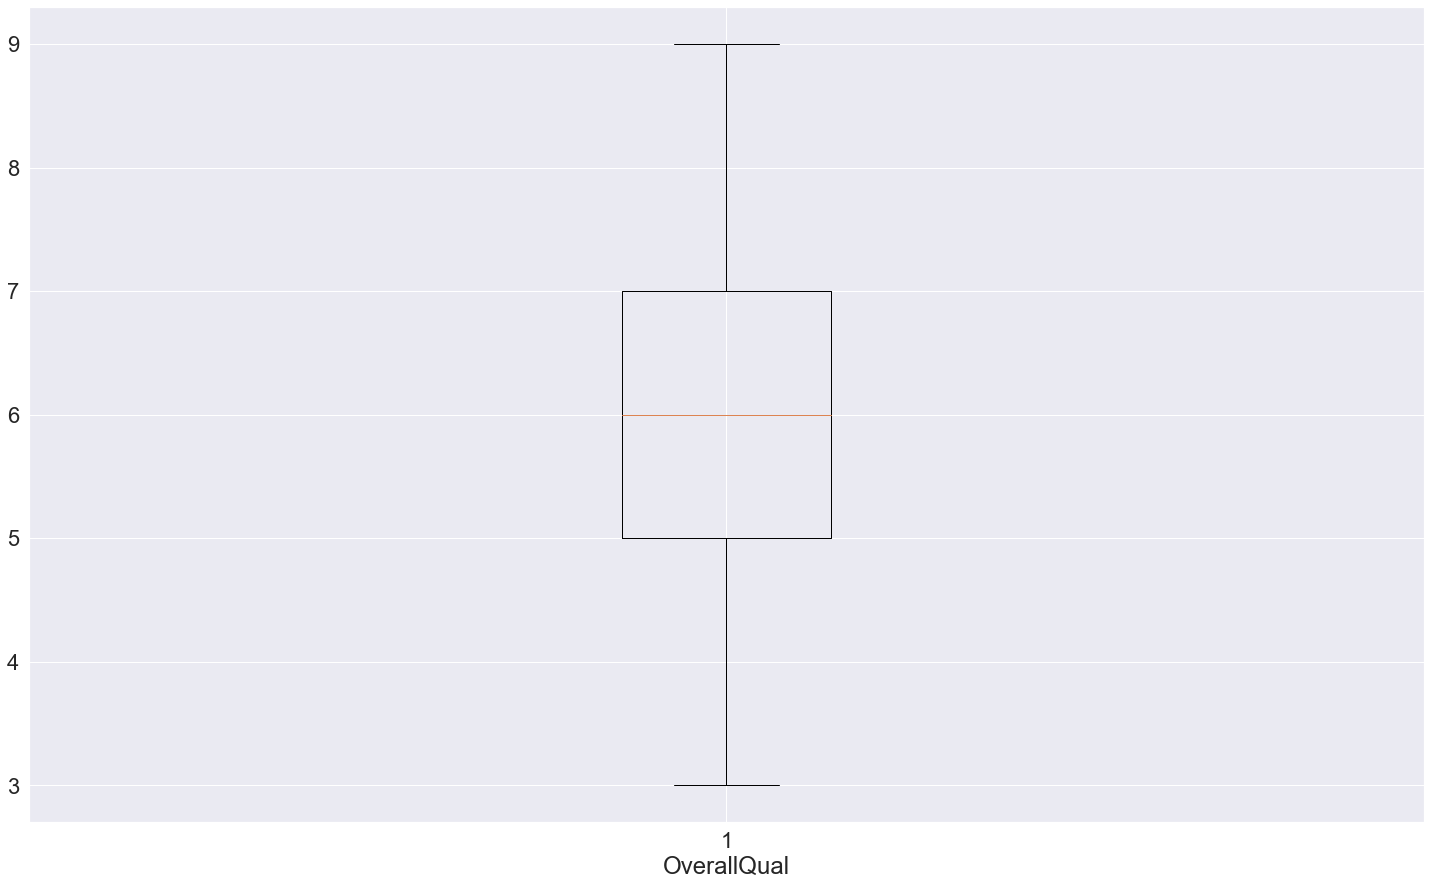

In [192]:
Q1 = q1(data_train['OverallQual'])
Q3 = q3(data_train['OverallQual'])
IQR = Q3-Q1
min_ = Q1 - 1.5 * IQR
max_ = Q3 + 1.5 * IQR
print('OverallQual Q1', Q1)
print('OverallQual Q3', Q3)
print('OverallQual IQR', IQR)
print('OverallQual min', min_)
print('OverallQual max', max_)

data_train = data_train[((max_ > data_train['OverallQual'])) & ((data_train['OverallQual'] > min_))]
# min(data_train.drop(data_train[((max_ < data_train['SalePrice'])) & ((data_train['SalePrice'] > min_))].index)['SalePrice'])
fig, aix = plt.subplots(nrows = 1, ncols = 1 ,figsize=(25,15))

aix.boxplot(data_train['OverallQual'])
aix.set_xlabel('OverallQual')
plt.show()
# data_train

Очистка GrLivArea

GrLivArea Q1 1118.0
GrLivArea Q3 1710.0
GrLivArea IQR 592.0
GrLivArea min 230.0
GrLivArea max 2598.0


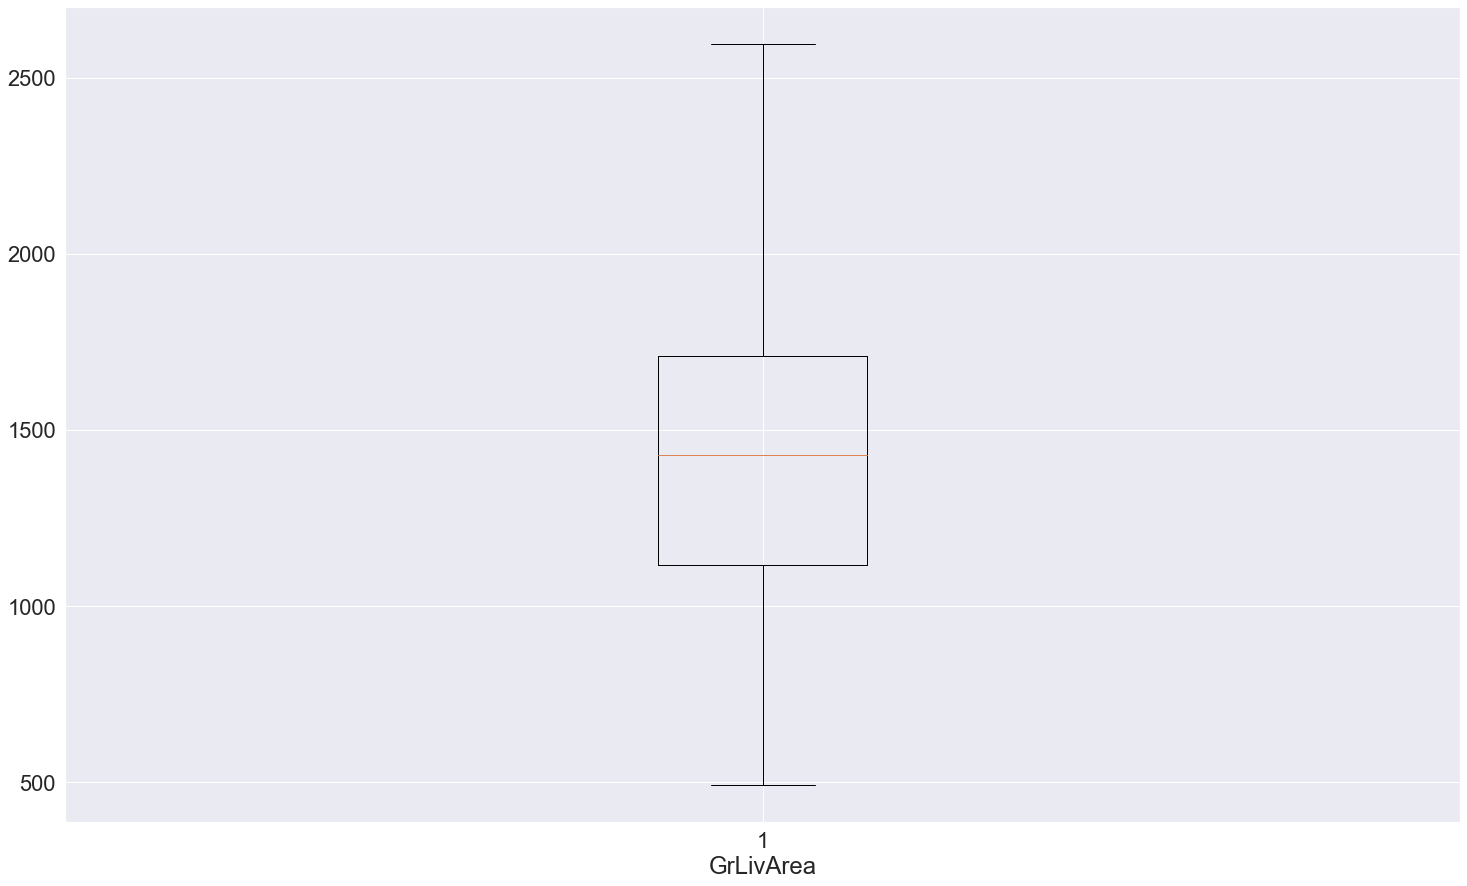

In [197]:
Q1 = q1(data_train['GrLivArea'])
Q3 = q3(data_train['GrLivArea'])
IQR = Q3-Q1
min_ = Q1 - 1.5 * IQR
max_ = Q3 + 1.5 * IQR
print('GrLivArea Q1', Q1)
print('GrLivArea Q3', Q3)
print('GrLivArea IQR', IQR)
print('GrLivArea min', min_)
print('GrLivArea max', max_)

data_train = data_train[((max_ > data_train['GrLivArea'])) & ((data_train['GrLivArea'] > min_))]
fig, aix = plt.subplots(nrows = 1, ncols = 1 ,figsize=(25,15))

aix.boxplot(data_train['GrLivArea'])
aix.set_xlabel('GrLivArea')
plt.show()
# data_train

Очистка GarageCars

GarageCars Q1 1.0
GarageCars Q3 2.0
GarageCars IQR 1.0
GarageCars min -0.5
GarageCars max 3.5


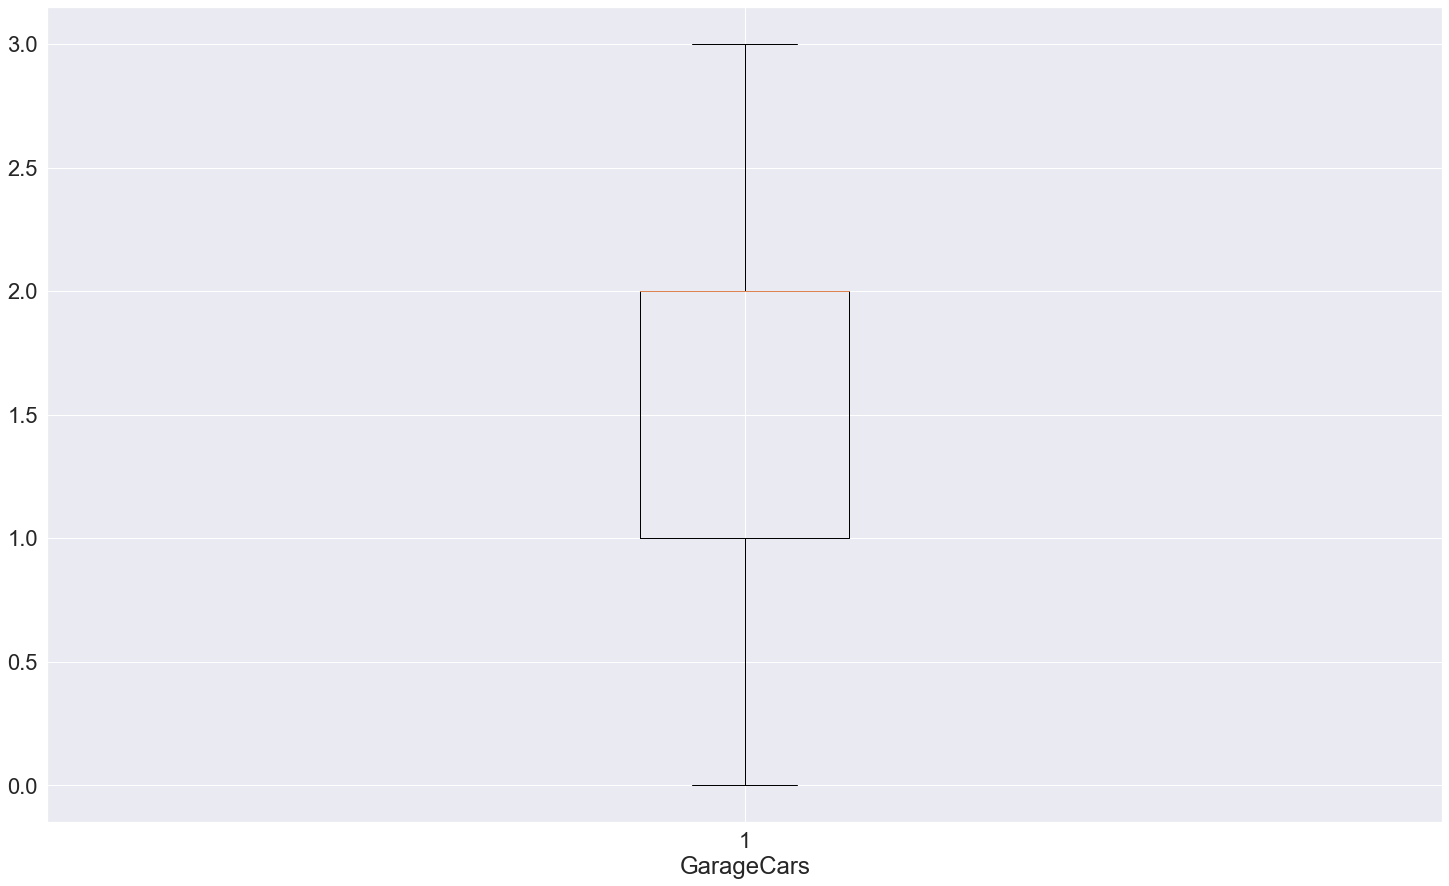

In [198]:
Q1 = q1(data_train['GarageCars'])
Q3 = q3(data_train['GarageCars'])
IQR = Q3-Q1
min_ = Q1 - 1.5 * IQR
max_ = Q3 + 1.5 * IQR
print('GarageCars Q1', Q1)
print('GarageCars Q3', Q3)
print('GarageCars IQR', IQR)
print('GarageCars min', min_)
print('GarageCars max', max_)

data_train = data_train[((max_ > data_train['GarageCars'])) & ((data_train['GarageCars'] > min_))]
# min(data_train.drop(data_train[((max_ < data_train['SalePrice'])) & ((data_train['SalePrice'] > min_))].index)['SalePrice'])
fig, aix = plt.subplots(nrows = 1, ncols = 1 ,figsize=(25,15))

aix.boxplot(data_train['GarageCars'])
aix.set_xlabel('GarageCars')
plt.show()
# data_train

Очистка GarageArea

GarageArea Q1 315.0
GarageArea Q3 576.0
GarageArea IQR 261.0
GarageArea min -76.5
GarageArea max 967.5


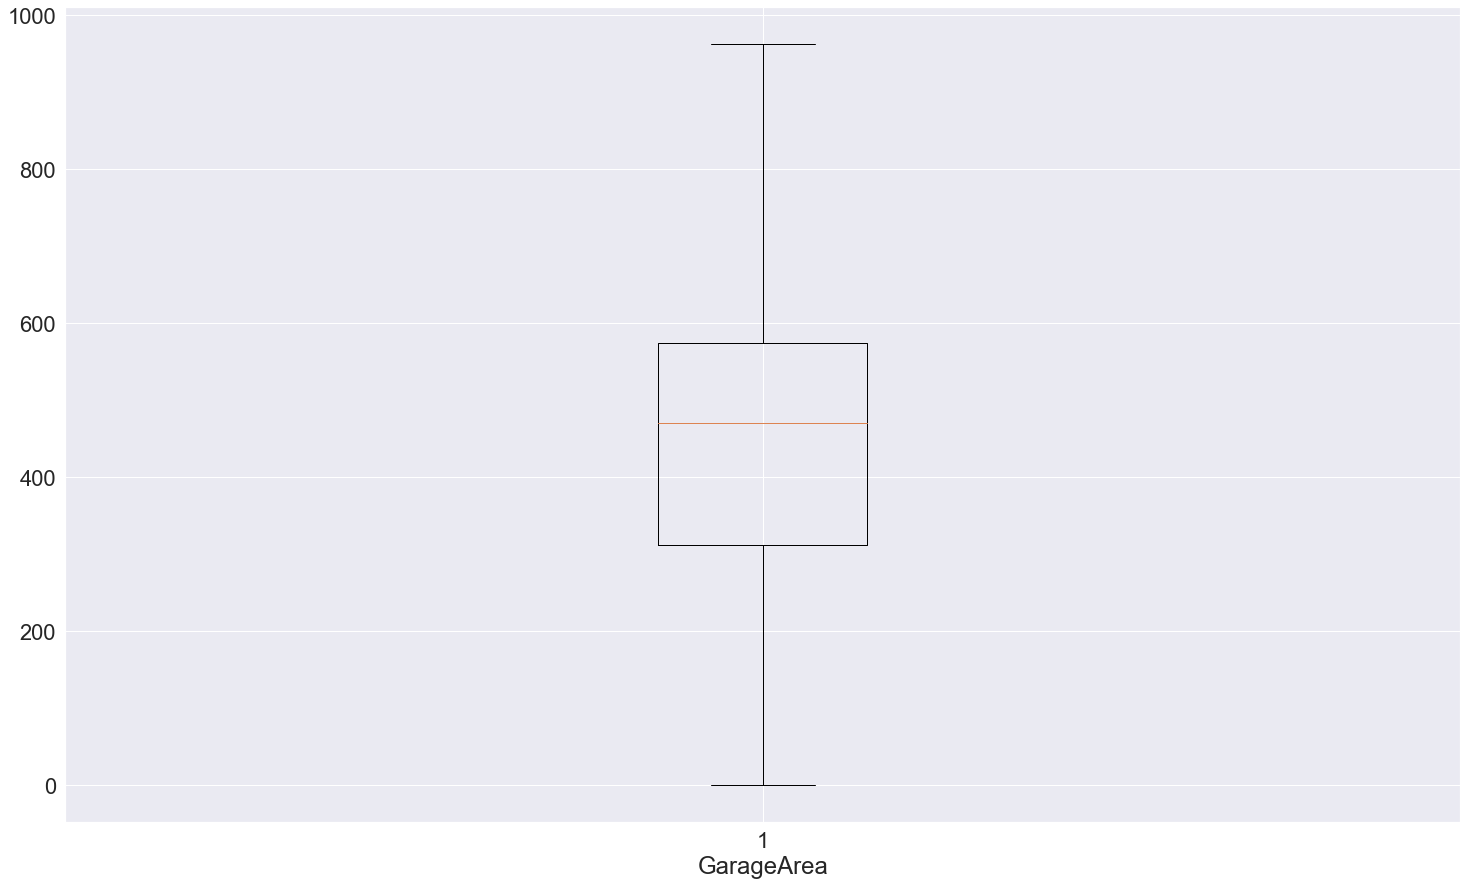

In [199]:
Q1 = q1(data_train['GarageArea'])
Q3 = q3(data_train['GarageArea'])
IQR = Q3-Q1
min_ = Q1 - 1.5 * IQR
max_ = Q3 + 1.5 * IQR
print('GarageArea Q1', Q1)
print('GarageArea Q3', Q3)
print('GarageArea IQR', IQR)
print('GarageArea min', min_)
print('GarageArea max', max_)
data_train = data_train[((max_ > data_train['GarageArea'])) & ((data_train['GarageArea'] > min_))]
# min(data_train.drop(data_train[((max_ < data_train['SalePrice'])) & ((data_train['SalePrice'] > min_))].index)['SalePrice'])
fig, aix = plt.subplots(nrows = 1, ncols = 1 ,figsize=(25,15))
aix.boxplot(data_train['GarageArea'])
aix.set_xlabel('GarageArea')
plt.show()
# data_train

Очистка TotalBsmtSF

TotalBsmtSF Q1 798.0
TotalBsmtSF Q3 1248.0
TotalBsmtSF IQR 450.0
TotalBsmtSF min 123.0
TotalBsmtSF max 1923.0


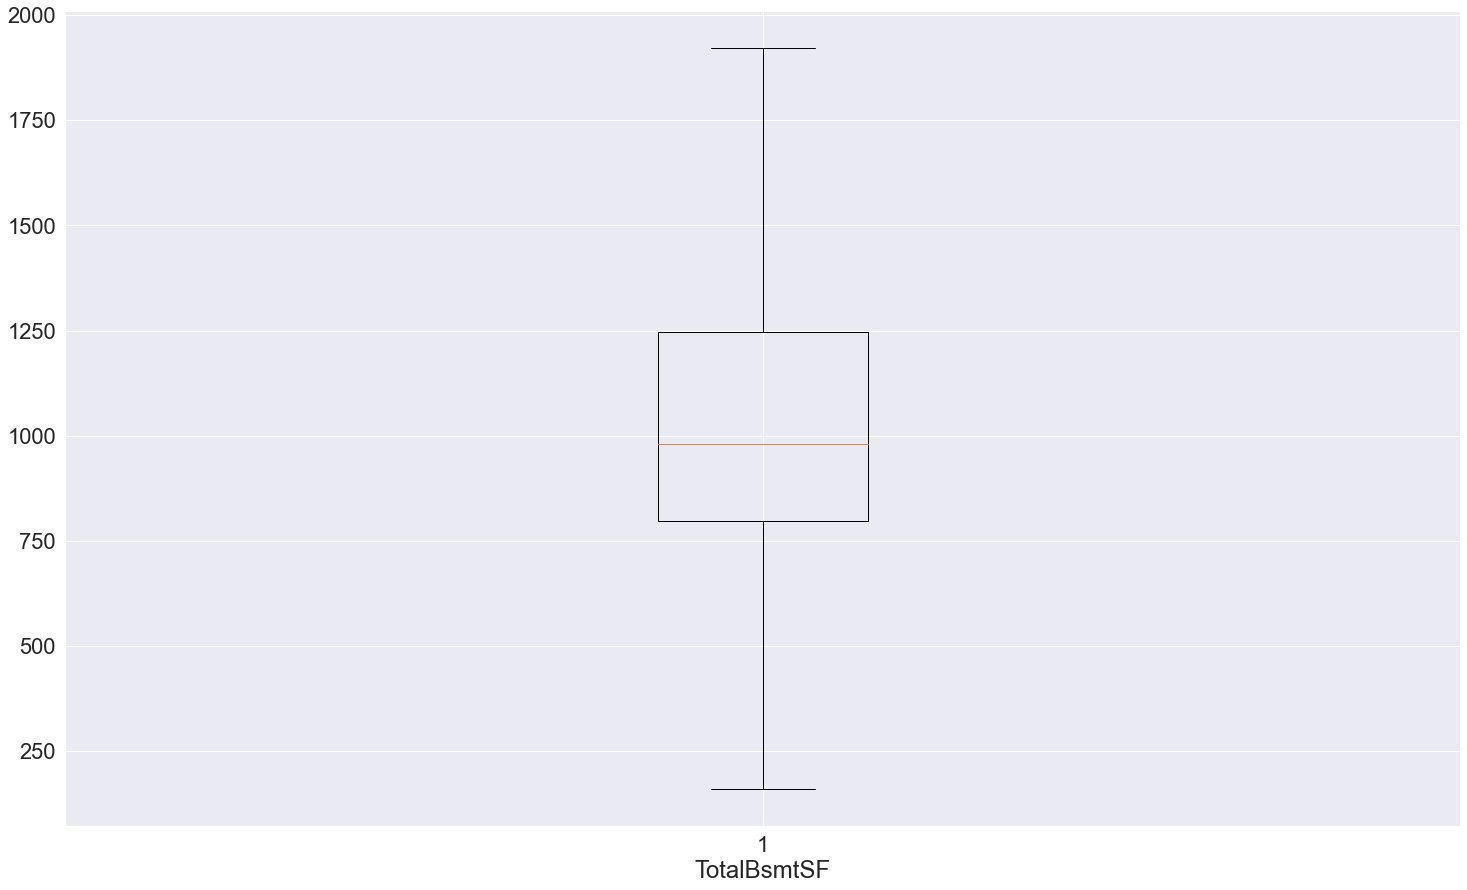

In [202]:
Q1 = q1(data_train['TotalBsmtSF'])
Q3 = q3(data_train['TotalBsmtSF'])
IQR = Q3-Q1
min_ = Q1 - 1.5 * IQR
max_ = Q3 + 1.5 * IQR
print('TotalBsmtSF Q1', Q1)
print('TotalBsmtSF Q3', Q3)
print('TotalBsmtSF IQR', IQR)
print('TotalBsmtSF min', min_)
print('TotalBsmtSF max', max_)
data_train = data_train[((max_ > data_train['TotalBsmtSF'])) & ((data_train['TotalBsmtSF'] > min_))]
# min(data_train.drop(data_train[((max_ < data_train['SalePrice'])) & ((data_train['SalePrice'] > min_))].index)['SalePrice'])
fig, aix = plt.subplots(nrows = 1, ncols = 1 ,figsize=(25,15))
aix.boxplot(data_train['TotalBsmtSF'])
aix.set_xlabel('TotalBsmtSF')
plt.show()
# data_train

Очистка 1stFlrSF

1stFlrSF Q1 864.0
1stFlrSF Q3 1329.0
1stFlrSF IQR 465.0
1stFlrSF min 166.5
1stFlrSF max 2026.5


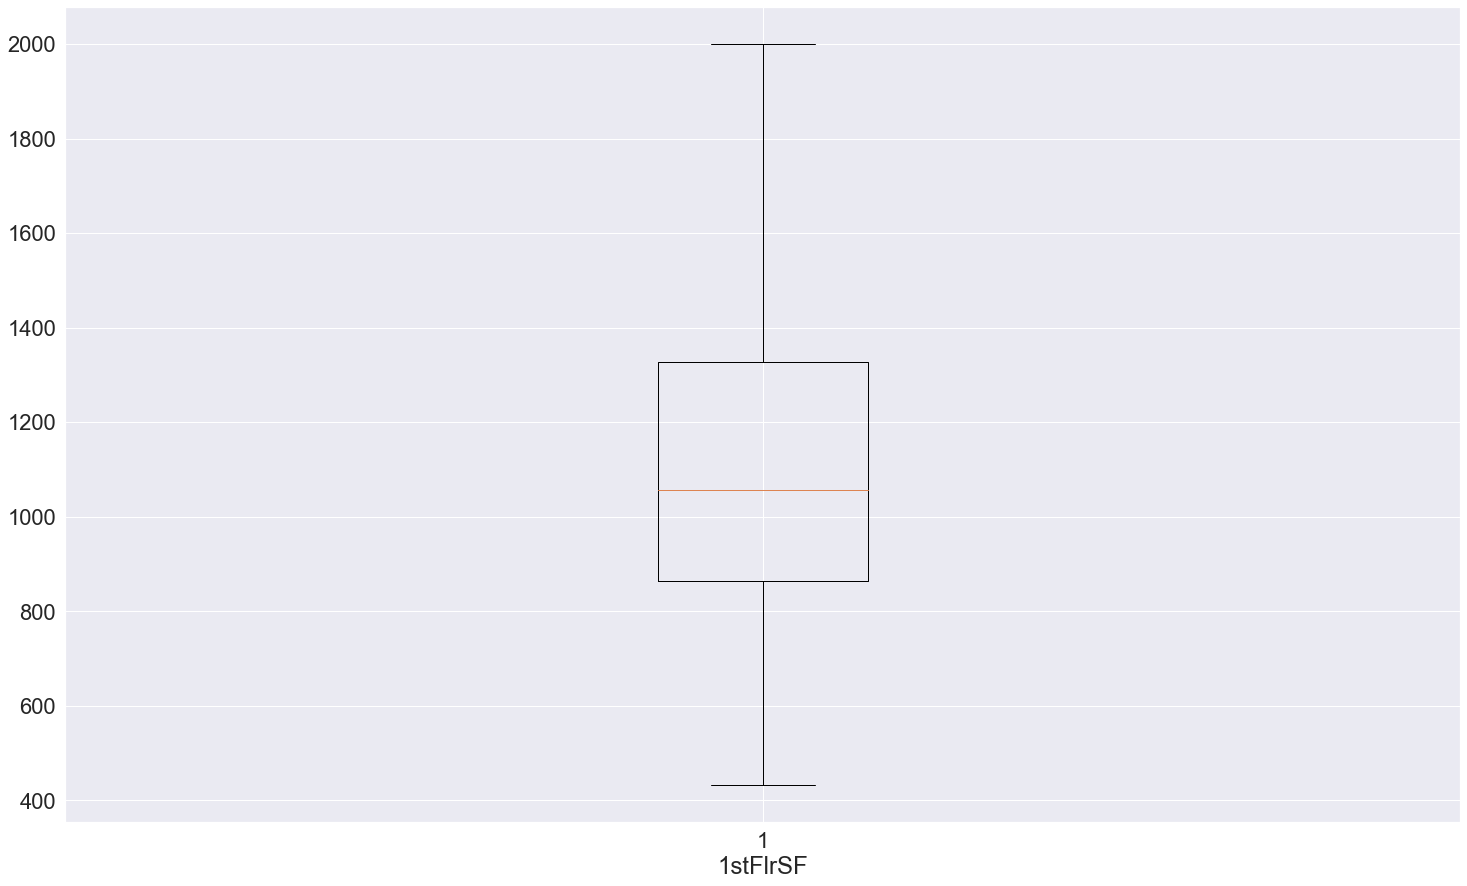

In [204]:
Q1 = q1(data_train['1stFlrSF'])
Q3 = q3(data_train['1stFlrSF'])
IQR = Q3-Q1
min_ = Q1 - 1.5 * IQR
max_ = Q3 + 1.5 * IQR
print('1stFlrSF Q1', Q1)
print('1stFlrSF Q3', Q3)
print('1stFlrSF IQR', IQR)
print('1stFlrSF min', min_)
print('1stFlrSF max', max_)
data_train = data_train[((max_ > data_train['1stFlrSF'])) & ((data_train['1stFlrSF'] > min_))]
# min(data_train.drop(data_train[((max_ < data_train['SalePrice'])) & ((data_train['SalePrice'] > min_))].index)['SalePrice'])
fig, aix = plt.subplots(nrows = 1, ncols = 1 ,figsize=(25,15))
aix.boxplot(data_train['1stFlrSF'])
aix.set_xlabel('1stFlrSF')
plt.show()
# data_train

**Разделяем данные для обучения и тренировки**

In [205]:
data_test = data_train.loc[1460:]

In [206]:
data_train = data_train.loc[0:1459]

**Строим диаграмму распределений исходного датасета и проводим описание данных**

Рисунок № 1. Диаграмма распределений значений цены

count      1312.000000
mean     171196.403963
std       60115.988554
min       34900.000000
25%      130000.000000
50%      159500.000000
75%      201200.000000
max      402000.000000
Name: SalePrice, dtype: float64


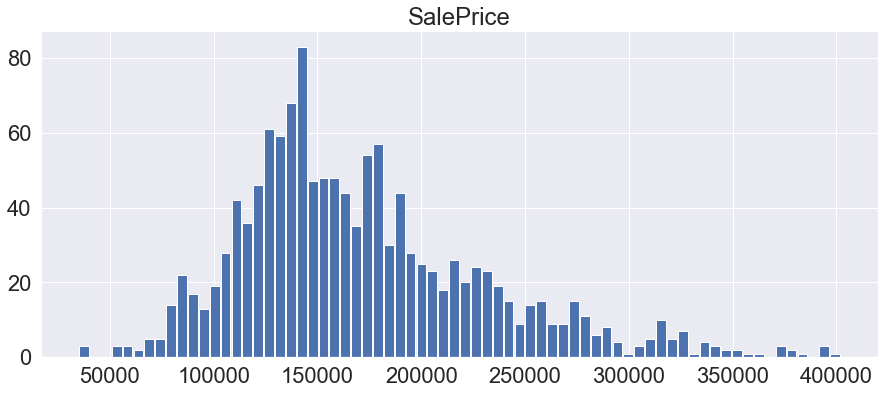

In [207]:
data_train.hist(column = 'SalePrice', bins = 70,figsize=(15,6), zorder=2, rwidth=0.9)
print(data_train['SalePrice'].describe())

**Строим диаграмму размаха цены исходного датасета**

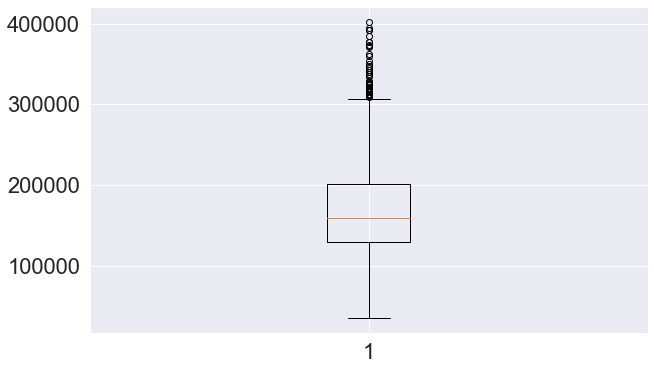

In [208]:
plt.figure(figsize=(10,6))
plt.boxplot(x=data_train['SalePrice'])
plt.show()

**Строим диаграмму рассеивания**

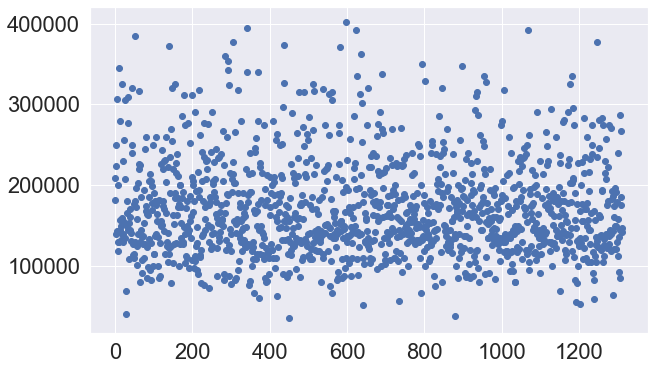

In [209]:
plt.figure(figsize=(10,6))
plt.scatter(x = list(range(data_train['SalePrice'].size)),
                       y = data_train['SalePrice'].tolist())
plt.show()

**Используя функцию log, преобразуме данные цены, для выравнивания данных**

In [210]:
data_train['SalePrice'] = np.log(data_train['SalePrice'])

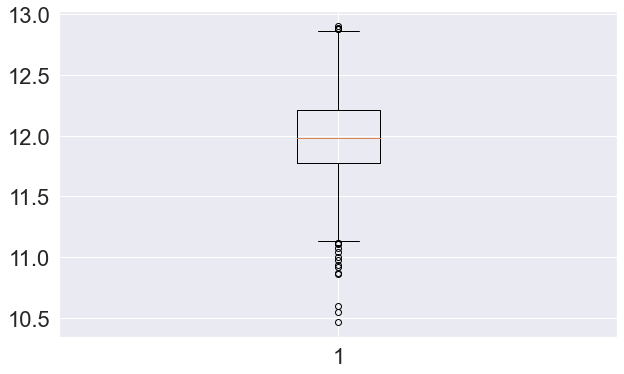

In [211]:
plt.figure(figsize=(10,6))
plt.boxplot(x=data_train['SalePrice'])
plt.show()

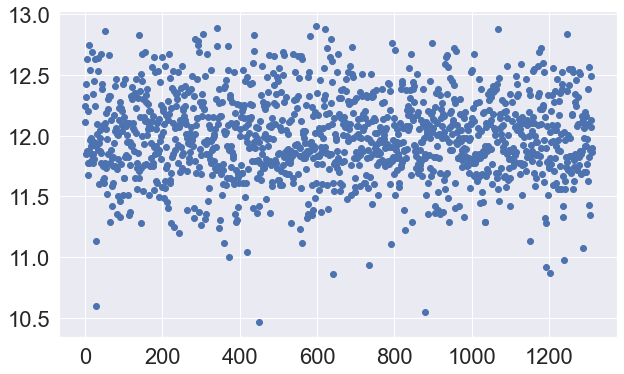

In [212]:
plt.figure(figsize=(10,6))
plt.scatter(x = list(range(data_train['SalePrice'].size)),
                       y = data_train['SalePrice'].tolist())
plt.show()

count    1312.000000
mean       11.991306
std         0.346699
min        10.460242
25%        11.775290
50%        11.979799
75%        12.212053
max        12.904207
Name: SalePrice, dtype: float64


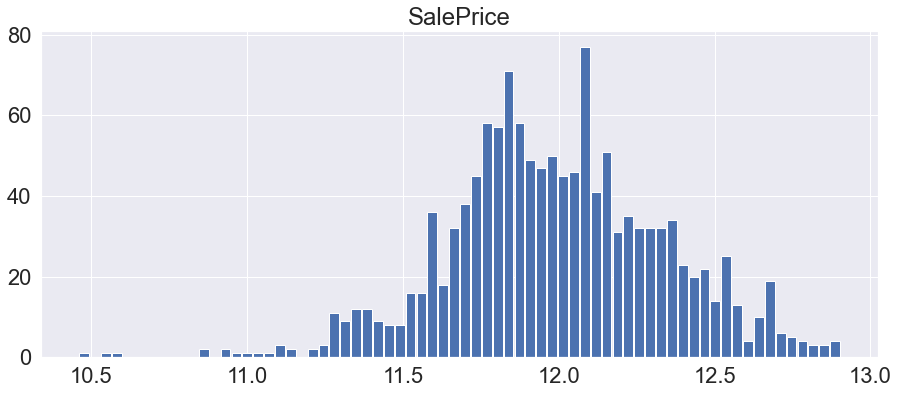

In [213]:
data_train.hist(column = 'SalePrice', bins = 70,figsize=(15,6), zorder=2, rwidth=0.9)
print(data_train['SalePrice'].describe())

**Проверяем корреляцию между выходной переменной и входными (измерение влияния факторов на выходную переменную)**

**Производим отбор переменных (признаков**

Отличная статья: https://loginom.ru/blog/feature-selection

В данной работе был выбран метод использующий корреляцию между входными переменными и выходной. 

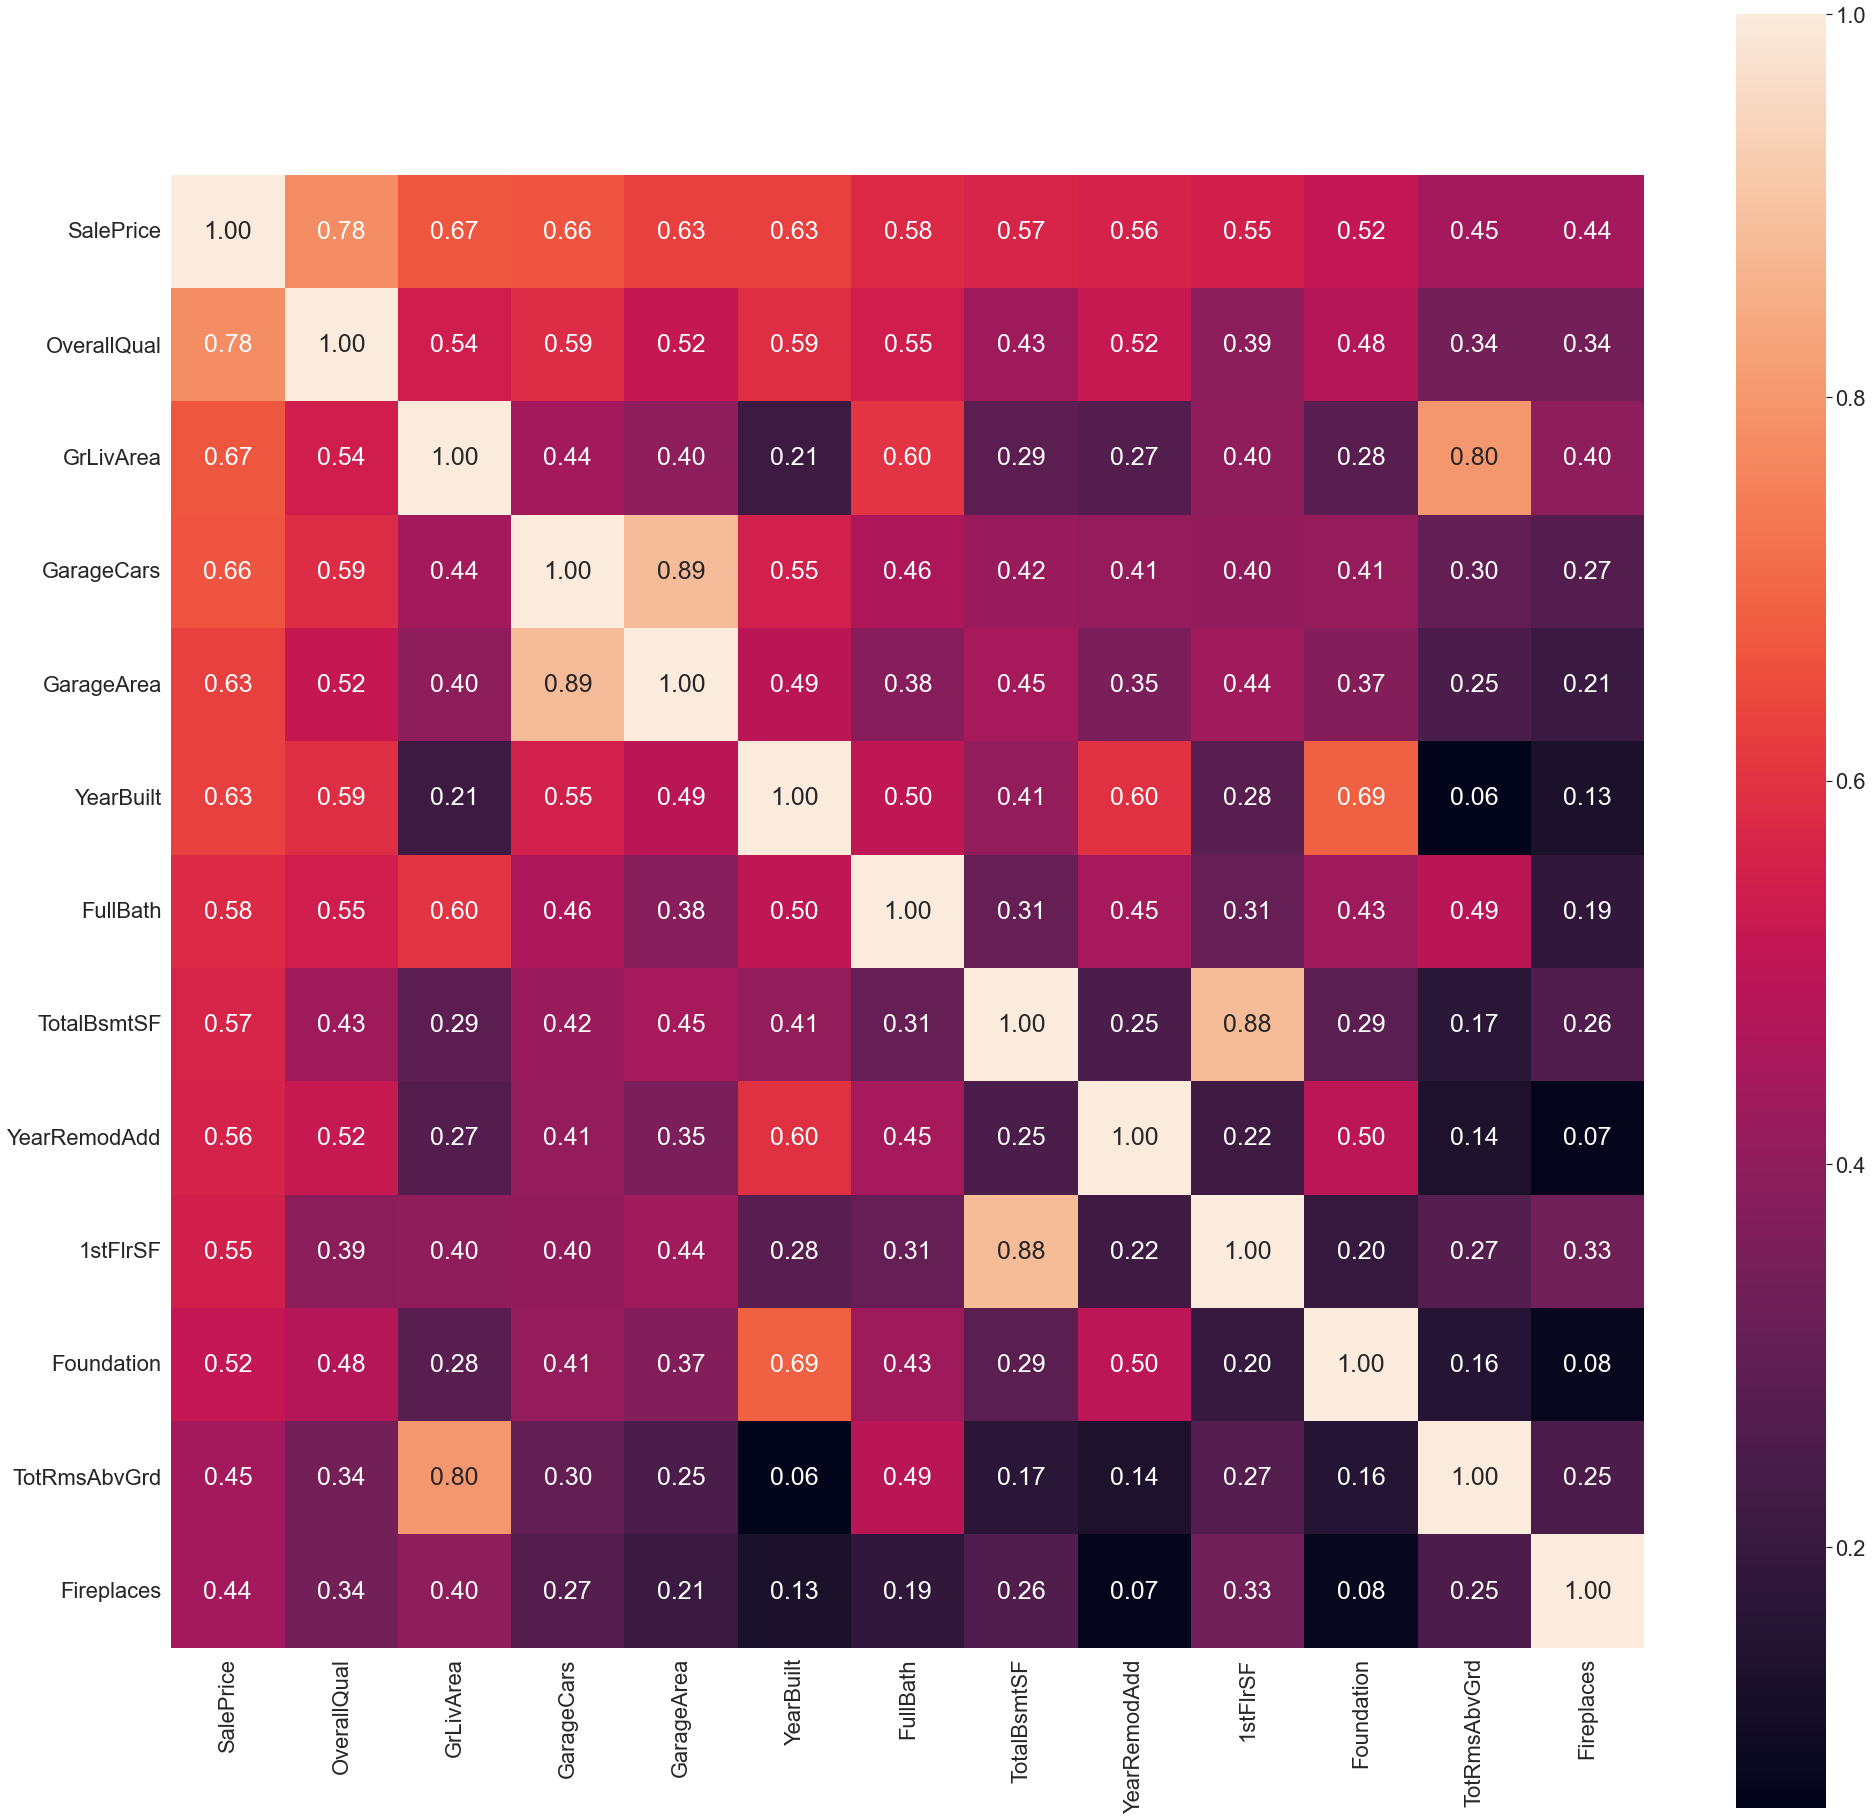

13


In [214]:
corrmat = data_train.corr()
k = 13 # количество коррелирующих признаков, которое мы хотим увидеть
corrmat.nlargest(k, 'SalePrice').index #Отображаем столбцы максимальной корреляции по возрастанию
cols = corrmat.nlargest(k, 'SalePrice').index
cm = np.corrcoef(data_train[cols].values.T)
plt.figure(figsize=(k+20,k+20))
sns.set(font_scale=2)
hm = sns.heatmap(cm, cbar=True, annot=True, square=True, 
                 fmt='.2f', annot_kws={'size': 25}, 
                 yticklabels=cols.values, xticklabels=cols.values)
plt.show()
print(k)

**Строим графики расределений максимально коррелиремых значений с ценой, а также диаграмму размаха для каждого значения**

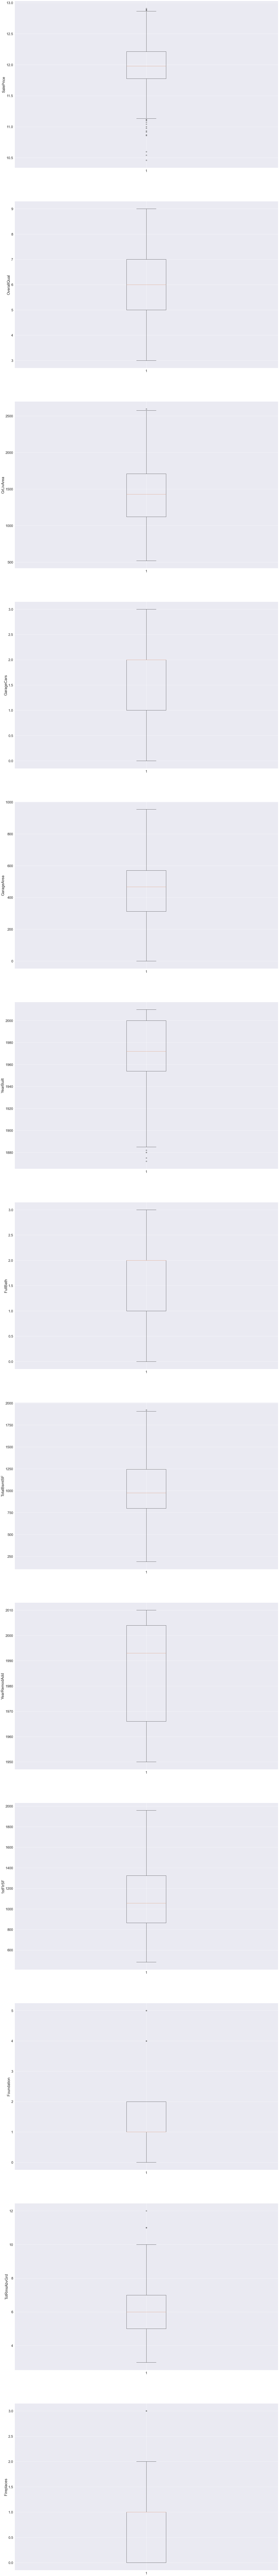

In [215]:
fig_1, axs_1 = plt.subplots(nrows = len(corrmat.nlargest(k, 'SalePrice').index)  , ncols= 1 ,figsize=(30,300))
for ctn, i in enumerate(corrmat.nlargest(k, 'SalePrice').index):
    axs_1[ctn].boxplot(data_train[i])
    axs_1[ctn].set_ylabel(i)

plt.show()

Можно наблюдать, что данные имеют большое количество выбросов. Соответстенно необходимо реализовать их фильтрацию, обратившись к рисунку № 1, можно заметить, что распределение имеет не симметричные хвосты, соответственно мы не може применять **метод стандартного отклонения**. По этому было принято решение использовать **Метод интерквартильных расстояний**.
Для реализации данного метода, нам необходимо найти первый (Q1) и третий (Q3) квартил, и на основе них найти "экстримальные" значения по формулам: Limmax = Q3 + Ni х IQR; Limmin = Q1 - Ni х IQR; где Q3 - третий квартиль, Q1 - первый квартиль, IQR - интерквартильное расстояние определяемое по формуле IQR = Q3 - Q1; Ni - заданное число интерквартильного размаха (1.5).

**Ручная подготовка данных**

Очистка SalePrice в тренировочном датасете

SalePrice Q1 11.77528972943772
SalePrice Q3 12.212053237006321
SalePrice IQR 0.4367635075686014
SalePrice min 11.120144468084817
SalePrice max 12.867198498359222


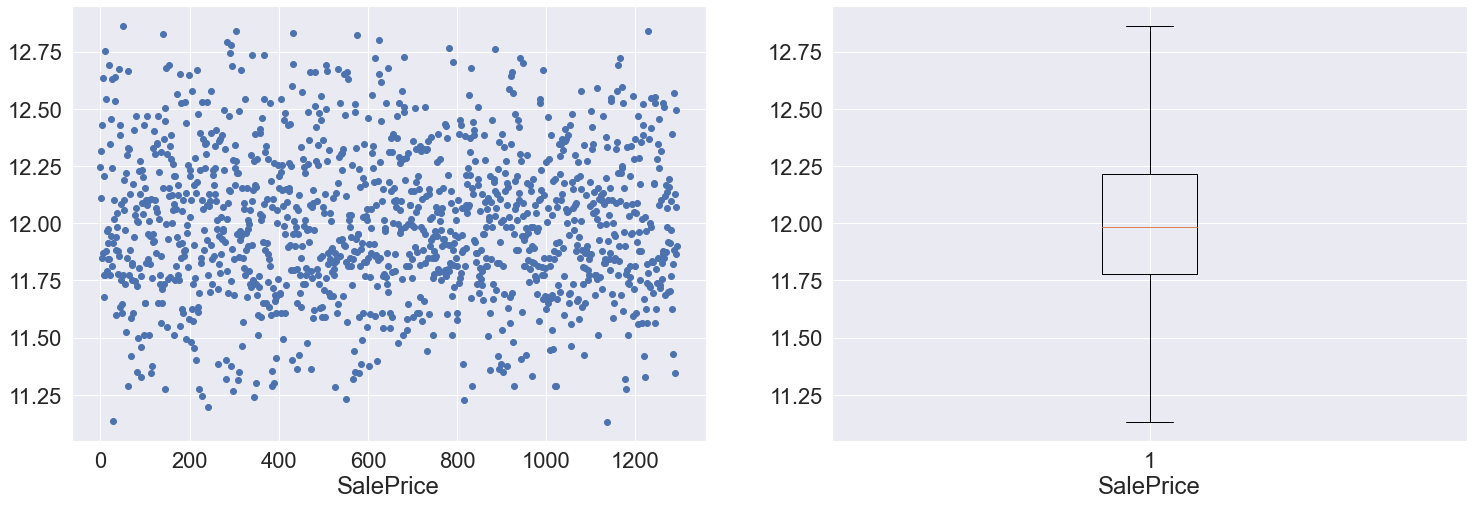

count    1294.000000
mean       12.000344
std         0.325478
min        11.133128
25%        11.775770
50%        11.982929
75%        12.214039
max        12.860999
Name: SalePrice, dtype: float64


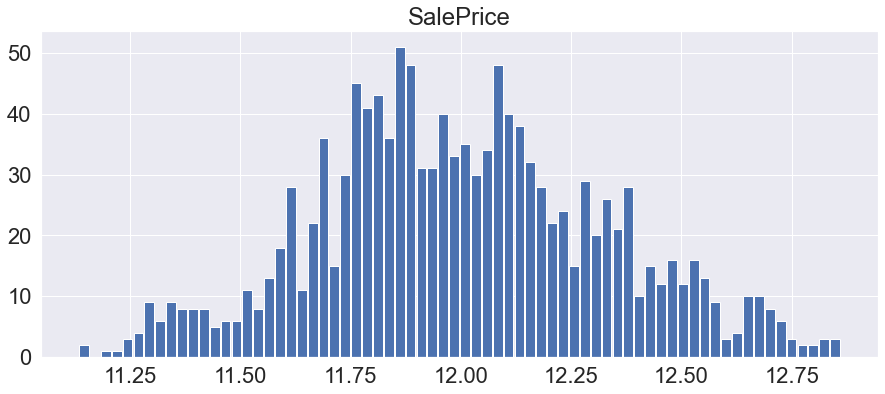

In [216]:
Q1 = q1(data_train['SalePrice'])
Q3 = q3(data_train['SalePrice'])
IQR = Q3-Q1
min_SalePrice = Q1 - 1.5 * IQR
max_SalePrice = Q3 + 1.5 * IQR
print('SalePrice Q1', Q1)
print('SalePrice Q3', Q3)
print('SalePrice IQR', IQR)
print('SalePrice min', min_SalePrice)
print('SalePrice max', max_SalePrice)

data_train.reset_index(drop= True , inplace= True )
data_train = data_train[((data_train['SalePrice'] > min_SalePrice) & (data_train['SalePrice'] < max_SalePrice))]
# min(data_train.drop(data_train[((max_ < data_train['SalePrice'])) & ((data_train['SalePrice'] > min_))].index)['SalePrice'])
fig, aix = plt.subplots(nrows = 1, ncols = 2 ,figsize=(25,8))
aix[0].scatter(x = list(range(data_train['SalePrice'].size)),
                       y = data_train['SalePrice'].tolist())
aix[1].boxplot(data_train['SalePrice'])
aix[0].set_xlabel('SalePrice')
aix[1].set_xlabel('SalePrice')
plt.show()

data_train.hist(column = 'SalePrice', bins = 70,figsize=(15,6), zorder=2, rwidth=0.9)
print(data_train['SalePrice'].describe())

# Подготавливаем данные для обучения

In [217]:
len(list(data_train[corrmat.nlargest(k, 'SalePrice').index].columns))
data_for_fit = data_train[corrmat.nlargest(k, 'SalePrice').index]
# -----------------------------------------------------------------------
# data_for_fit = data_for_fit.drop('EnclosedPorch',axis=1)
# data_for_fit = data_for_fit.drop('MSZoning',axis=1)
# data_for_fit = data_for_fit.drop('BsmtFinSF1',axis=1)
# data_for_fit = data_for_fit.drop('BsmtFinSF2',axis=1)
# data_for_fit = data_for_fit.drop('LandSlope',axis=1)
# -----------------------------------------------------------------------
# data_train['LandSlope']
# Отделяем значения для обучения модели
test_size = 0.2
train_size = 0.8
random_state = 20

train, test= train_test_split(data_for_fit, 
                              test_size = test_size, 
                              train_size = train_size,
                              random_state = random_state)   
train_X = train.drop('SalePrice', axis = 1)
train_Y = train['SalePrice']
test_X = test.drop('SalePrice', axis = 1)
test_Y = test['SalePrice']
train_X = tf.convert_to_tensor(train_X)
train_Y = tf.convert_to_tensor(train_Y)
test_X = tf.convert_to_tensor(test_X)
test_Y = tf.convert_to_tensor(test_Y)
data_for_fit.head(1)

SalePrice  OverallQual  GrLivArea  GarageCars  GarageArea  YearBuilt  \
0  12.247694            7       1710         2.0       548.0       2003   

   FullBath  TotalBsmtSF  YearRemodAdd  1stFlrSF  Foundation  TotRmsAbvGrd  \
0         2        856.0          2003       856           2             8   

   Fireplaces  
0           0

OverallQual  GrLivArea  GarageCars  GarageArea  YearBuilt  FullBath  \
0               7       1710         2.0       548.0       2003         2   
1               6       1262         2.0       460.0       1976         2   
2               7       1786         2.0       608.0       2001         2   
3               7       1717         3.0       642.0       1915         1   
4               8       2198         3.0       836.0       2000         2   
5               5       1362         2.0       480.0       1993         1   
6               8       1694         2.0       636.0       2004         2   
7               7       2090         2.0       484.0       1973         2   
8               7       1774         2.0       468.0       1931         2   
9               5       1077         1.0       205.0       1939         1   
10              5       1040         1.0       384.0       1965         1   
11              9       2324         3.0       736.0       2005         3   
12              5        912         1.0       352.0       1962         1   
13              7       1494         3.0       840.0       2006         2   
14              6       1253         1.0       352.0       1960         1   
15              7        854         2.0       576.0       1929         1   
16              6       1004         2.0       480.0       1970         1   
17              5       1114         2.0       576.0       2004         1   
18              5       1339         1.0       294.0       1958         1   
19              8       2376         3.0       853.0       2005         3   
20              7       1108         1.0       280.0       1930         1   
21              8       1795         2.0       534.0       2002         2   
22              5       1060         2.0       572.0       1976         1   
23              5       1060         1.0       270.0       1968         1   
24              8       1600         3.0       890.0       2007         2   
25              5        900         2.0       576.0       1951         1   
26              8       1704         3.0       772.0       2007         2   
27              5       1600         1.0       319.0       1957         1   
28              4        520         1.0       240.0       1927         1   
30              5       1228         1.0       271.0       1966         1   
31              8       1234         2.0       484.0       2007         2   
32              5       1700         2.0       447.0       1959         1   
33              9       1561         2.0       556.0       2005         2   
34              8       2452         3.0       691.0       2004         3   
35              5       1097         2.0       672.0       1994         1   
36              5       1297         2.0       498.0       1954         1   
37              5       1057         1.0       246.0       1953         1   
38              6       1324         2.0       440.0       1965         2   
39              5       1328         1.0       308.0       1959         1   
40              5        884         2.0       504.0       1983         1   
41              5        938         1.0       308.0       1975         1   
42              5       1150         1.0       300.0       1959         1   
43              9       1752         2.0       576.0       2005         2   
44              7       2149         2.0       670.0       2003         1   
45              8       1656         3.0       826.0       2006         2   
46              4       1452         0.0         0.0       1920         2   
47              5        955         1.0       386.0       1966         1   
48              6       1470         2.0       388.0       1997         2   
49              6       1176         2.0       528.0       1934         1   
50              5        816         2.0       516.0       1963         1   
51              9       1842         3.0       894.0       1981         0   
52

**Данные для првоерки**

Количество пропущенных значений -  0


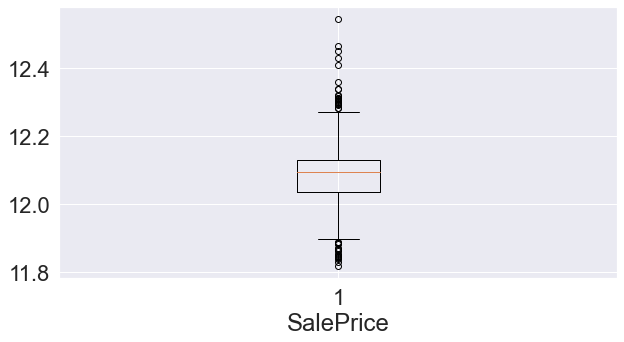

The lists l1 and l2 are the same


In [285]:
data_for_test = data_test[corrmat.nlargest(k, 'SalePrice').index]
Y_check = pd.read_csv(r'sample_submission.csv')

data_for_test['SalePrice'] = np.log(Y_check.iloc[data_for_test.index - 1460]['SalePrice'].tolist())
X_check = data_for_test
print('Количество пропущенных значений - ', X_check.isna().sum().sum())

# # ---------------------------------------------------------------------------------------------------
X_check = X_check[(X_check['SalePrice'] < max_SalePrice) &  (X_check['SalePrice'] > min_SalePrice)].reset_index().drop(['index'],axis=1)
fig, aix = plt.subplots(nrows = 1, ncols = 1 ,figsize=(10,5))
aix.boxplot(X_check['SalePrice'])
aix.set_xlabel('SalePrice')
plt.show()
# ---------------------------------------------------------------------------------------------------
Y_check = X_check['SalePrice']
X_check = X_check.drop('SalePrice', axis=1)

if collections.Counter(list(data_for_fit.drop('SalePrice', axis = 1).columns)) == collections.Counter(list(X_check.columns)):
    print ("The lists l1 and l2 are the same")
else:
    print ("The lists l1 and l2 are NOT THE SAME")


In [336]:
def PrintScatterAndCalculateLoos(test_X, test_Y):
    temp = test_X
    plt.figure(figsize=(20,10))
    plt.scatter(x = list(range(len(temp))), y = temp, label='Predict')
    plt.scatter(x = list(range(len(test_Y.numpy().tolist()))), y = test_Y.numpy().tolist(), label = 'Real')
    plt.legend(loc='lower right')
    plt.show()

    mse = mean_squared_error(test_Y.numpy().tolist(), temp)
    print('Mean squared error: ', mse)
    mae = mean_absolute_error(test_Y.numpy().tolist(), temp)
    print('Mean absolute error: ', mae)
    r2 = r2_score(test_Y.numpy().tolist(), temp)
    print('Coefficient of determination: ', r2)
    mape = mean_absolute_percentage_error(test_Y.numpy().tolist(), temp)
    print('Mean absolute percentage error: ', mape*100,'%')
    msle = mean_squared_log_error(temp, test_Y.numpy().tolist())
    print('Mean squared log error: ', msle)
    rmsle = np.sqrt(msle)
    print('Root Mean Squared Log Error: ', rmsle)
    rmse = np.sqrt(mean_squared_error(test_Y.numpy().tolist(), temp))
    print('Root Mean Squared Error: ', rmse)
    
#     plt.figure(figsize=(40,10))
#     plt.plot(temp,'g:', label = 'Predict')
#     plt.plot(test_Y.numpy().tolist(), 'b:', label = 'Real')
#     plt.legend(loc='lower right')
#     plt.show()

## Градиентный бустинг ##

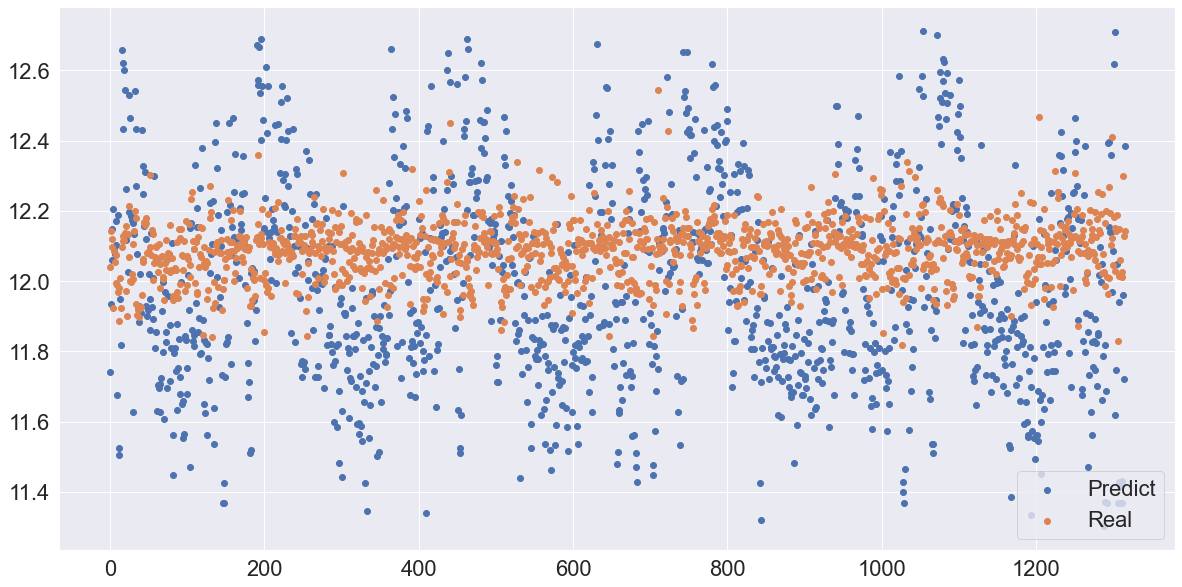

Mean squared error:  0.08426605883878366
Mean absolute error:  0.24725289922634391
Coefficient of determination:  -10.889506313394772
Mean absolute percentage error:  2.0464281131683286 %
Mean squared log error:  0.0004998639414590147
Root Mean Squared Log Error:  0.022357637206534477
Root Mean Squared Error:  0.29028616715025135


In [337]:
model_lgb = LGBMRegressor(boosting_type = 'gbdt', objective='regression', learning_rate=0.001, 
                       n_estimators=4000, max_bin=200, bagging_fraction=0.8,
                       bagging_freq=4, bagging_seed=8, feature_fraction=0.2,
                       feature_fraction_seed=8, min_sum_hessian_in_leaf = 11,
                       verbose=-1, random_state=42, force_row_wise=True)

model_lgb.fit(data_for_fit.drop('SalePrice', axis=1), data_for_fit['SalePrice'])
# model_lgb.fit(X_check, Y_check_log)
lgb_train_pred = model_lgb.predict(X_check)
PrintScatterAndCalculateLoos(lgb_train_pred, tf.convert_to_tensor(Y_check_log))

## XGBoost ##

-----------------------------------------------------
Check isna train_X_log:  0
Check isna Y_check_log:  0
Check isna test_Y_log:  0


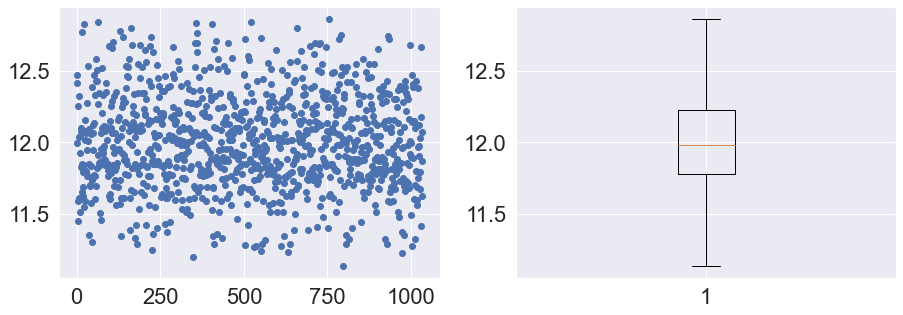

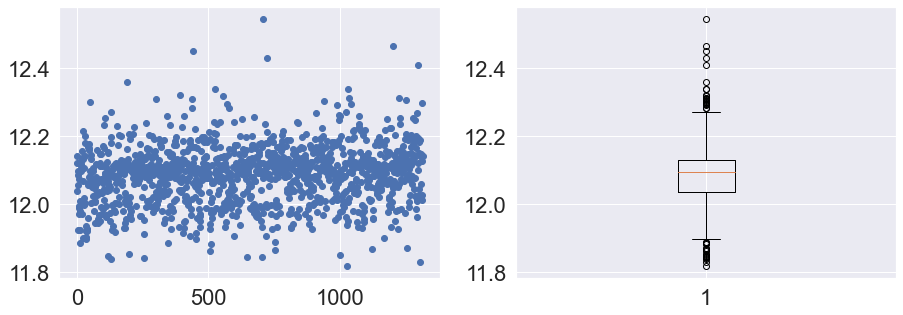

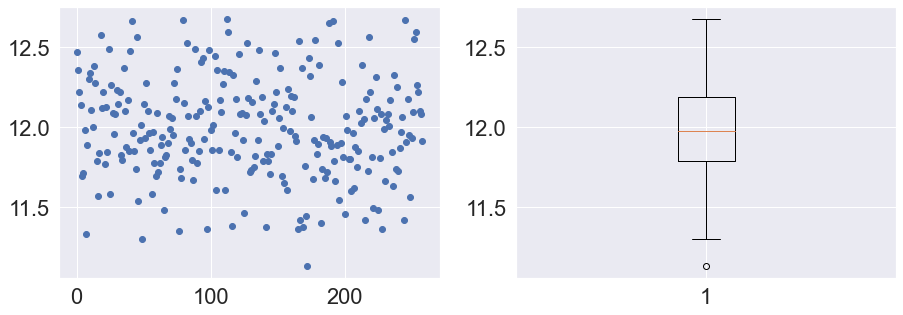

In [274]:
# Преобразуем данные log
train_Y_log = train_Y
test_Y_log = test_Y
Y_check_log = Y_check
# train_Y_log = tf.convert_to_tensor(np.log(train_Y))
# Y_check_log = tf.convert_to_tensor(np.log(Y_check))
# test_Y_log = tf.convert_to_tensor(np.log(test_Y))
print('-----------------------------------------------------')
print('Check isna train_X_log: ', np.isnan(train_Y_log).sum())
print('Check isna Y_check_log: ', np.isnan(Y_check_log).sum())
print('Check isna test_Y_log: ', np.isnan(test_Y).sum())

fig_1, axs_1 = plt.subplots(1  , ncols = 2 ,figsize=(15,5))
axs_1[0].scatter(x = list(range(len(train_Y_log))), y = train_Y_log)
axs_1[1].boxplot(np.array(train_Y_log))
plt.show()

fig_2, axs_2 = plt.subplots(1  , ncols = 2 ,figsize=(15,5))
axs_2[0].scatter(x = list(range(len(Y_check_log))), y = Y_check_log)
axs_2[1].boxplot(np.array(Y_check_log))
plt.show()

fig_3, axs_3 = plt.subplots(1  , ncols = 2 ,figsize=(15,5))
axs_3[0].scatter(x = list(range(len(test_Y_log))), y = test_Y_log)
axs_3[1].boxplot(np.array(test_Y_log))
plt.show()

[11:41:14] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0fdc6d574b9c0d168-1\xgboost\xgboost-ci-windows\src\objective\regression_obj.cu:213: reg:linear is now deprecated in favor of reg:squarederror.
------------------------------------------------------------
Оптимальное количество деревьев:  743
------------------------------------------------------------


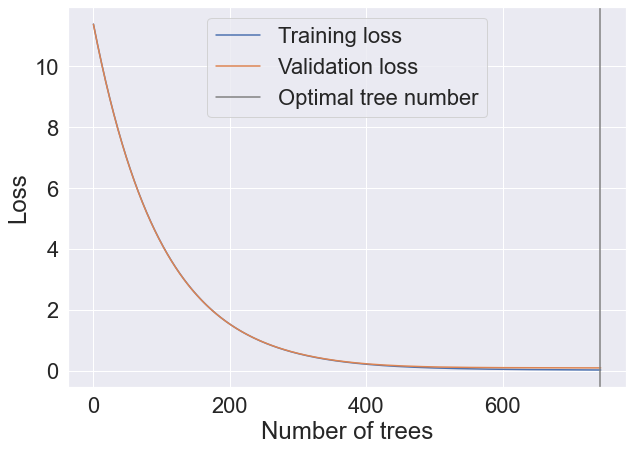

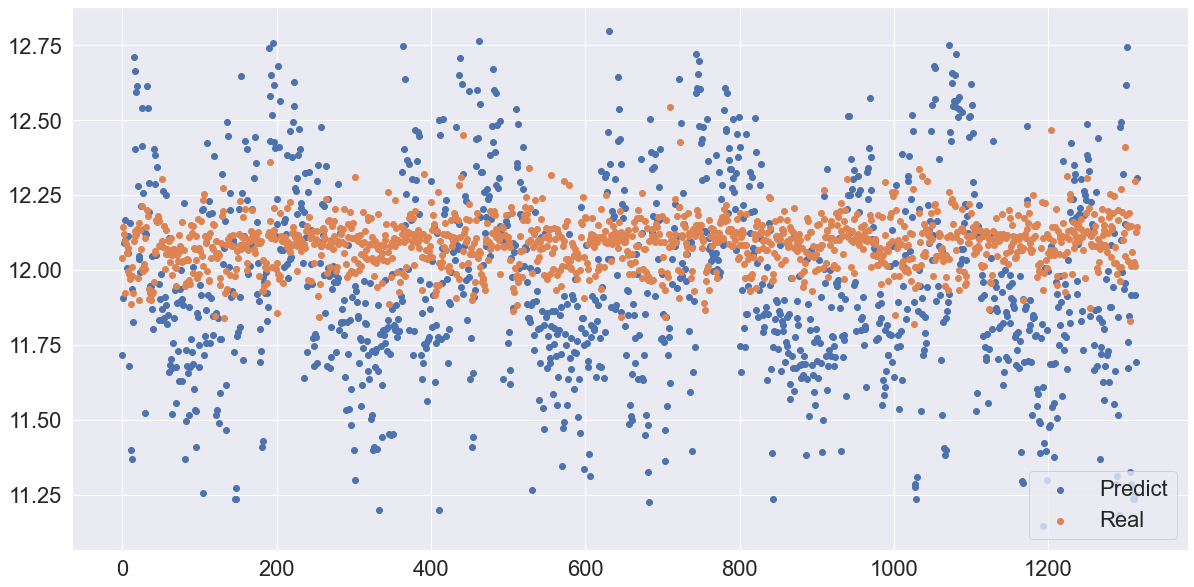

Mean squared error:  0.1068281694281745
Mean absolute error:  0.27585262927585225
Coefficient of determination:  -14.072903757071224
Mean absolute percentage error:  2.2828932767937933 %
Mean squared log error:  0.0006374619256443061
Root Mean Squared Log Error:  0.02524800835005221
Root Mean Squared Error:  0.3268457884510285


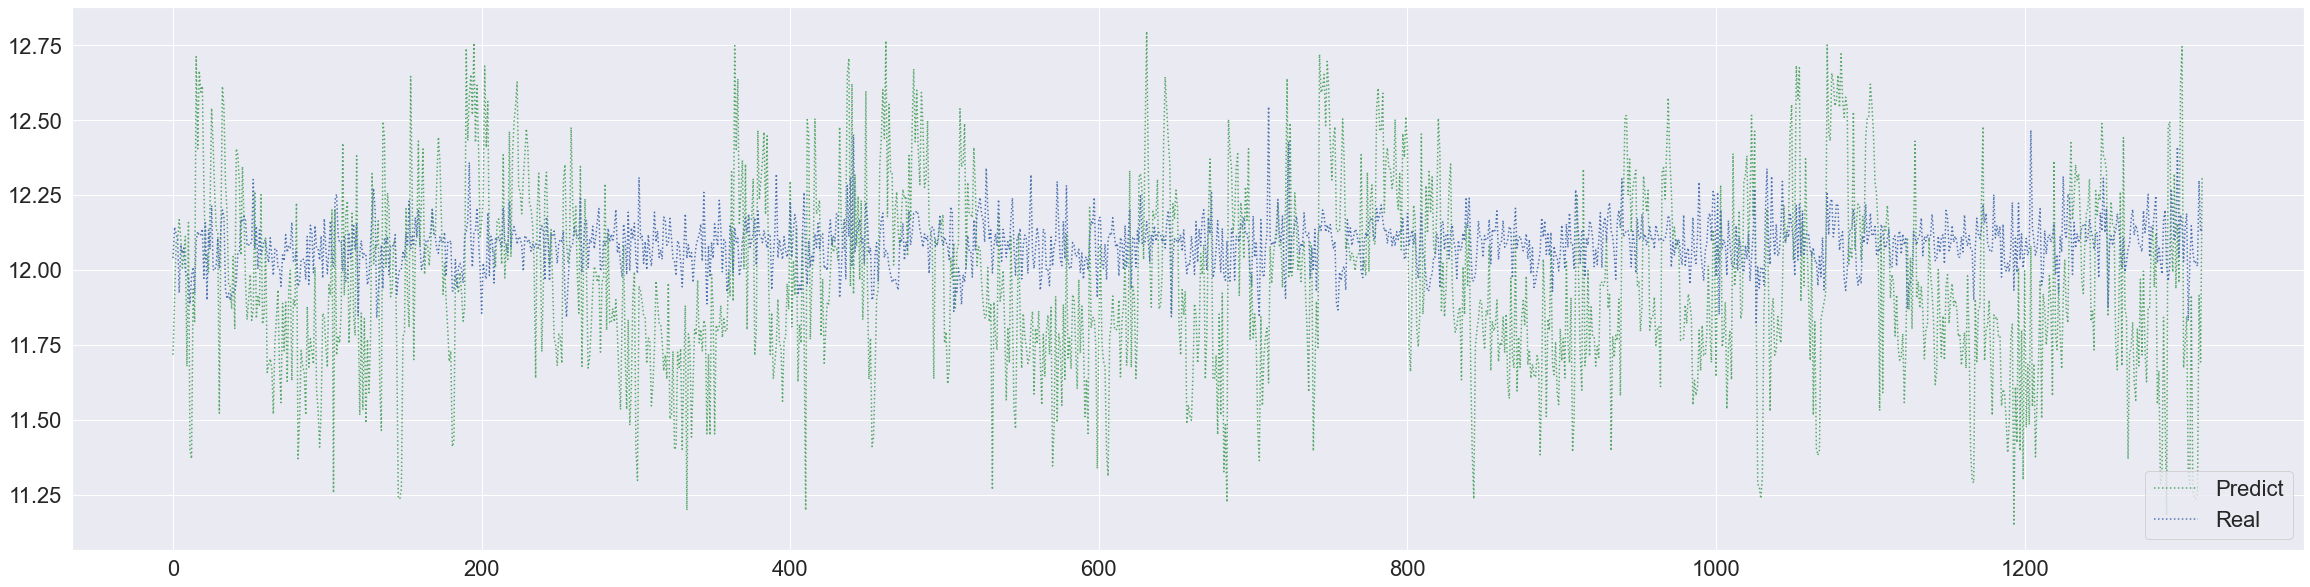

In [284]:
eval_metric = 'mae'
# xgboost_ = XGBRegressor(booster = "gbtree", learning_rate=0.001, n_estimators=10000,
#                        max_depth=7, min_child_weight=0, gamma=0,
#                        subsample=0.5, colsample_bytree=0.3, objective='reg:linear',
#                        nthread=-1, scale_pos_weight=100, seed=27,
#                        reg_alpha=5, reg_lambda=4, random_state=42,
#                        eta=0.05)
# xgboost_ = XGBRegressor(learning_rate=0.01,
#                        n_estimators=7200,
#                        max_depth=1,
#                        min_child_weight=0,
#                        gamma=0,
#                        subsample=0.5,
#                        colsample_bytree=0.7,
#                        objective='reg:linear',
#                        nthread=-1,
#                        scale_pos_weight=10,
#                        seed=27,
#                        reg_alpha=0,
#                        reg_lambda=0,
#                        random_state=42,
#                        eta=0.05,
#                        max_delta_step = 0.8)
# xgboost_ = XGBRegressor(objective = "reg:linear",
#         booster = "gbtree",
#         eta=0.05, #default = 0.3
#         gamma=0,
#         max_depth=3, #default=6
#         min_child_weight=4, #default=1
#         subsample=1,
#         colsample_bytree=1)
xgboost_ = XGBRegressor(learning_rate=0.01,n_estimators=3460,
                                     max_depth=15, min_child_weight=0,
                                     gamma=0, subsample=0.7,
                                     colsample_bytree=0.7,
                                     objective='reg:linear', nthread=-1,
                                     scale_pos_weight=1, seed=27,
                                     reg_alpha=0.00006)
xgboost_.fit(train_X, train_Y_log, eval_set=[(train_X, train_Y_log),(test_X, test_Y_log)],
             eval_metric = eval_metric, verbose=False, early_stopping_rounds =2)

print('------------------------------------------------------------')
print('Оптимальное количество деревьев: ', xgboost_.best_ntree_limit)
print('------------------------------------------------------------')

# ------------------------------------------------------------------------------
results = xgboost_.evals_result()
plt.figure(figsize=(10,7))
plt.plot(results["validation_0"][eval_metric], label="Training loss")
plt.plot(results["validation_1"][eval_metric], label="Validation loss")
plt.axvline(xgboost_.best_ntree_limit, color="gray", label="Optimal tree number")
plt.xlabel("Number of trees")
plt.ylabel("Loss")
plt.legend()
# ------------------------------------------------------------------------------

# fig, ax = plt.subplots(figsize=(30, 30))
# plot_tree(xgboost_, ax=ax)
PrintScatterAndCalculateLoos(xgboost_.predict(tf.convert_to_tensor(X_check)), tf.convert_to_tensor(Y_check_log))

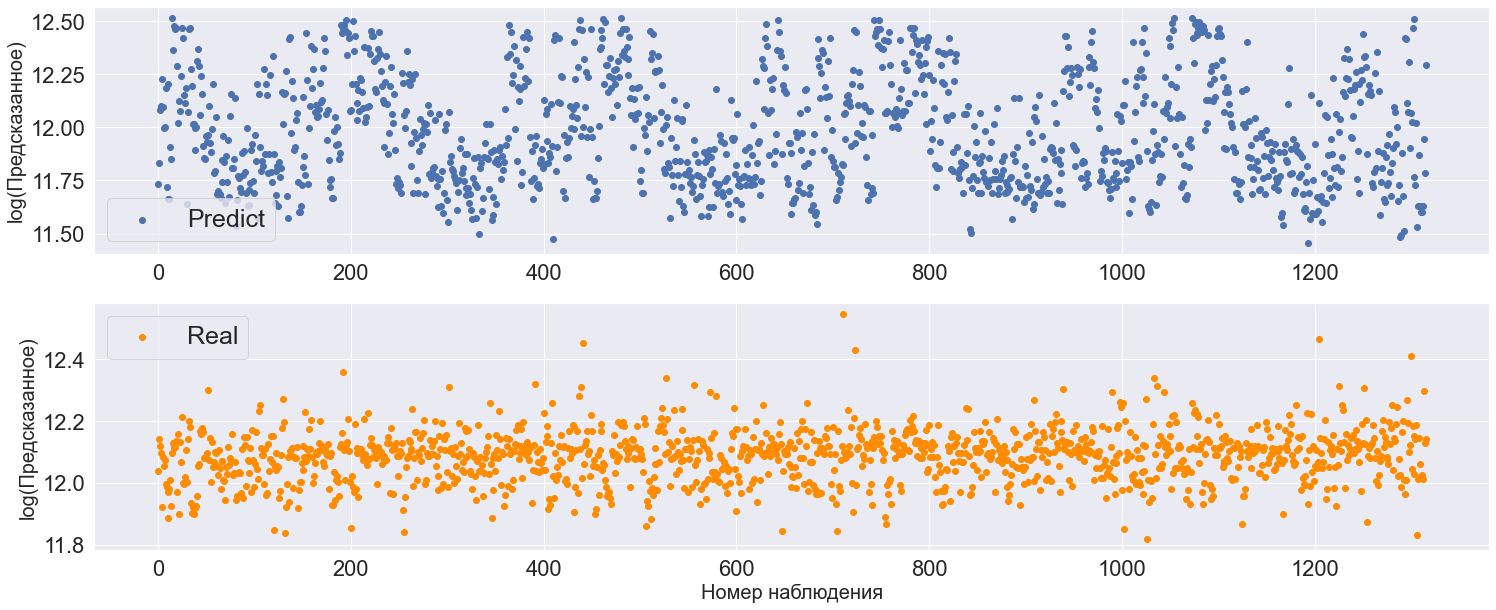

In [1550]:
fig, ax = plt.subplots(2, ncols= 1, figsize=(25, 10))
ax[0].scatter(x = list(range(len(Y_check_log))), y = xgboost_.predict(tf.convert_to_tensor(X_check)), label='Predict')
ax[1].scatter(x = list(range(len(Y_check_log))), y = Y_check_log, label = 'Real', color='darkorange')
plt.xlabel('Номер наблюдения', fontsize=20)
ax[0].set_ylabel('log(Предсказанное)', fontsize=20)
ax[1].set_ylabel('log(Предсказанное)', fontsize=20)

leg = ax[1].legend(prop={"size":25})
leg = ax[0].legend(prop={"size":25})

plt.show()

In [ ]:
pd.DataFrame({'Pred': pow(2.718281828, xgboost_.predict(tf.convert_to_tensor(X_check+1)))}).describe()

In [ ]:
pd.read_csv(r'sample_submission.csv').describe()

In [1554]:
modelCatBoostRegressor = CatBoostRegressor(iterations=1000,
                           task_type="GPU",
                           devices='0:1', verbose=500, learning_rate=0.01)

In [1555]:
modelCatBoostRegressor.fit(train_X.numpy(), train_Y_log.numpy())

0:	learn: 0.3256432	total: 12.3ms	remaining: 12.3s
500:	learn: 0.1134933	total: 5.07s	remaining: 5.05s
999:	learn: 0.1056906	total: 10.2s	remaining: 0us


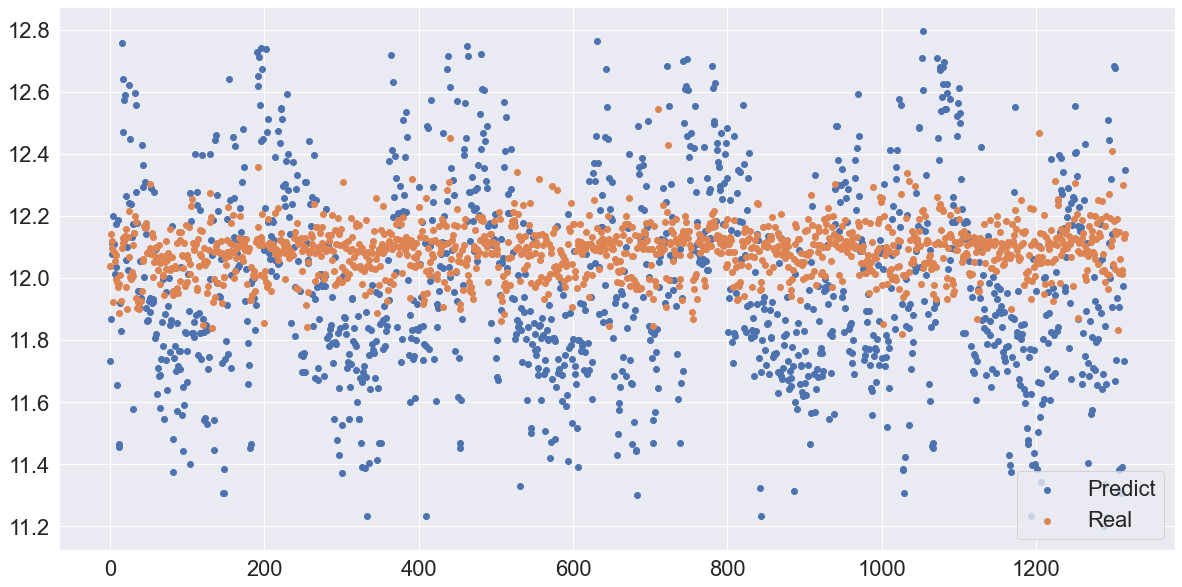

Mean squared error:  0.10232189460316186
Mean absolute error:  0.2719556284878745
Coefficient of determination:  -13.437091619655579
Mean absolute percentage error:  2.2505629764472603 %
Mean squared log error:  0.0006078130965629982
Root Mean Squared Log Error:  0.02465386575291993
Root Mean Squared Error:  0.31987793703717965


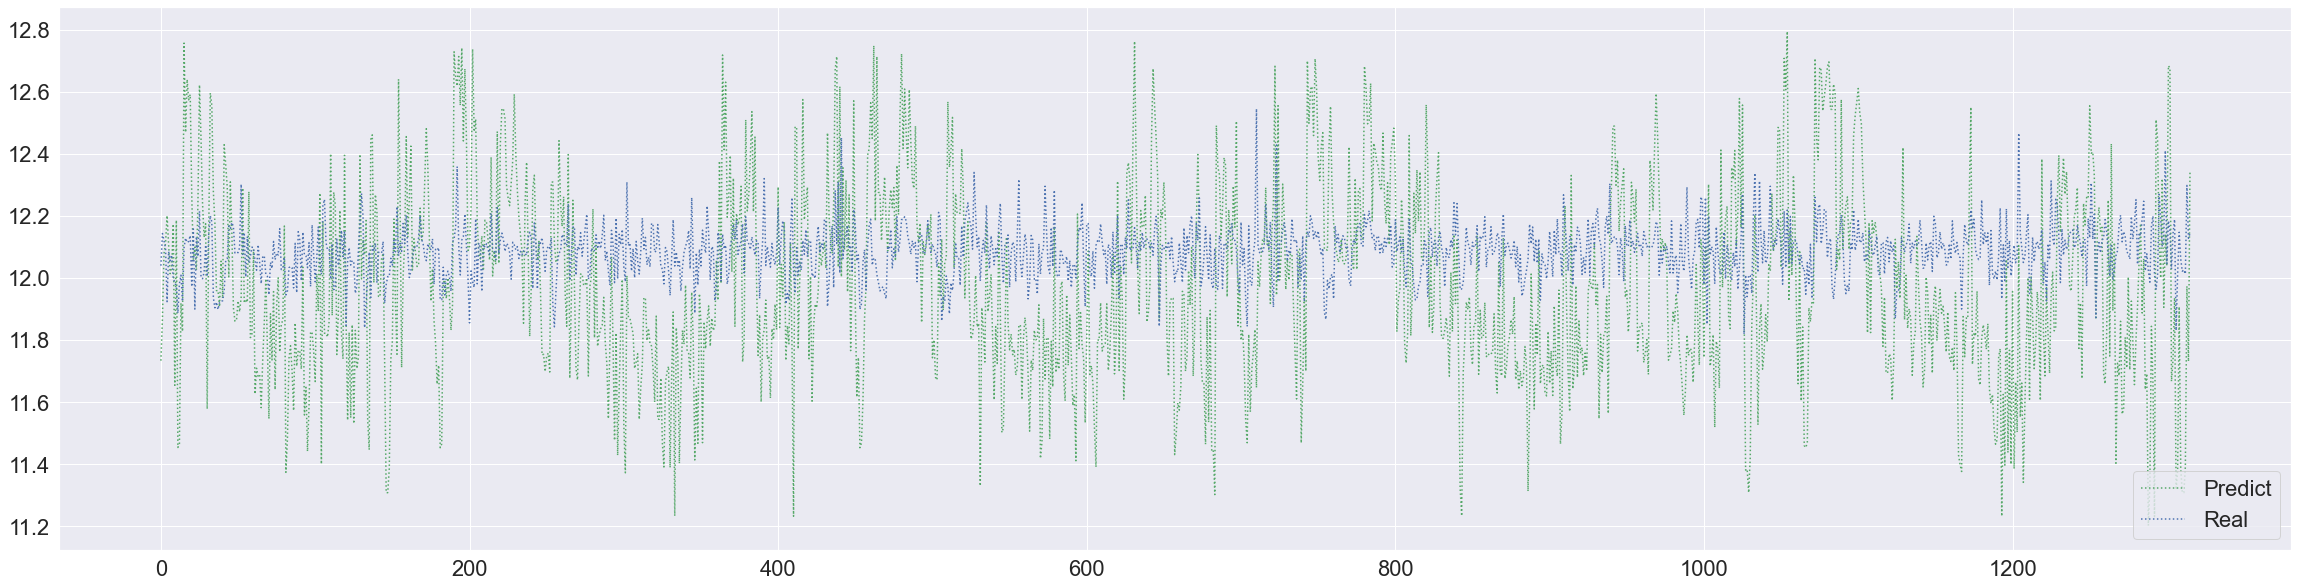

In [1556]:
PrintScatterAndCalculateLoos(modelCatBoostRegressor.predict(X_check.numpy()), Y_check_log)

Без какой либо предобработки данных мы получаем наихудшие предиктивные данные.

Произведя предобработку, очистив от выбросов, мы получаем улучшение на 6-7% но данное качество тоже не устраивает.